<a href="https://colab.research.google.com/github/jhanvi0905/MNIST_GAN/blob/main/MNIST_BasicGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 x 784
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 1 x 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)   # 1 x 28 x 28  = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()


In [3]:
#setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download =True, transform=transforms.ToTensor()), shuffle = True, batch_size = bs)

#number of steps = 468.75


100%|██████████| 9912422/9912422 [00:00<00:00, 221500859.05it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 84063632.08it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29874131.85it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5321376.75it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
#declare our models

#Generator

def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace = True)
  )
class Generator(nn.Module):
  def __init__(self, z_dim = 64, i_dim = 784, h_dim = 128):
    super().__init__()
    self.gen = nn.Sequential(
      genBlock(z_dim, h_dim), #64, 128
      genBlock(h_dim, h_dim*2), #128, 256
      genBlock(h_dim*2, h_dim*4), #256, 512
      genBlock(h_dim*4, h_dim*8), #512, 1024
      nn.Linear(h_dim*8, i_dim), #1024, 784
      nn.Sigmoid(),
    )

  def forward(self, noise):
      return self.gen(noise)
def gen_noise(number , z_dim ):
  return torch.randn(number, z_dim).to(device)

In [5]:
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2),
  )
class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim = 256):
      super().__init__()
      self.disc = nn.Sequential(
        discBlock(i_dim, h_dim*4),
        discBlock(h_dim*4, h_dim*2),
        discBlock(h_dim*2, h_dim),
        nn.Linear(h_dim, 1),
        )
    def forward(self, image):
      return self.disc(image)

In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [7]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [8]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)


torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([1, 2, 3, 1, 7, 4, 9, 1, 1, 7])


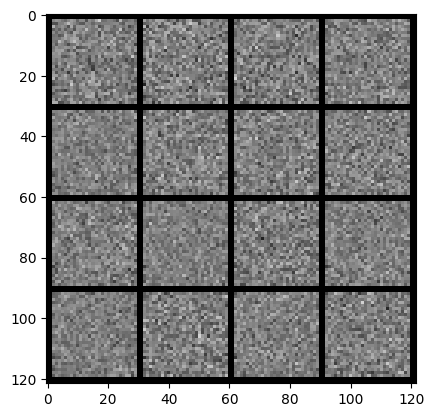

In [9]:
show(fake)

In [12]:
#generator loss

def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)

  return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss = (disc_fake_loss+disc_real_loss)/2

  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

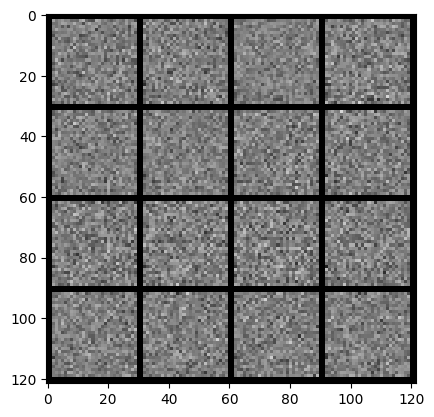

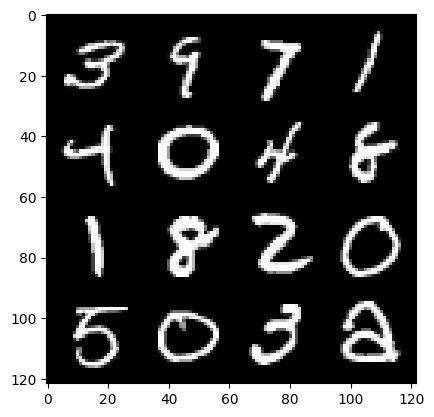

0: step 0/ Gen Loss : 0.002353818615277608/ disc_loss 0.0023047979672749836


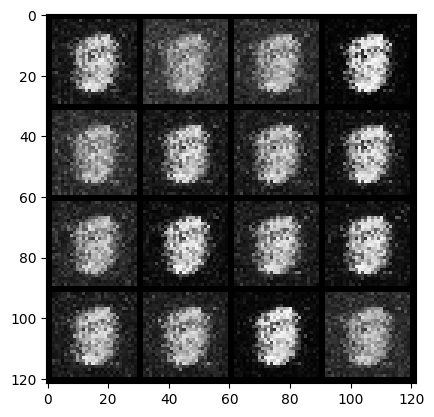

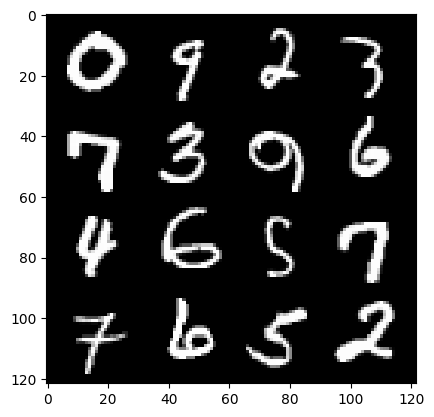

0: step 300/ Gen Loss : 0.011902321179707845/ disc_loss 0.0004739492138226827


  0%|          | 0/469 [00:00<?, ?it/s]

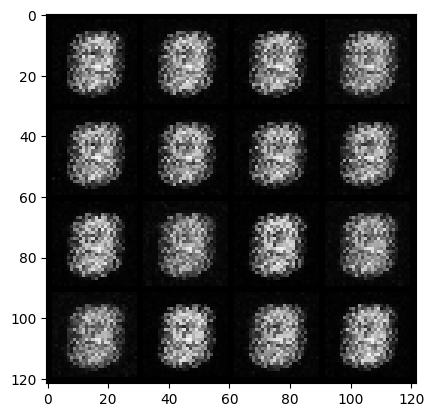

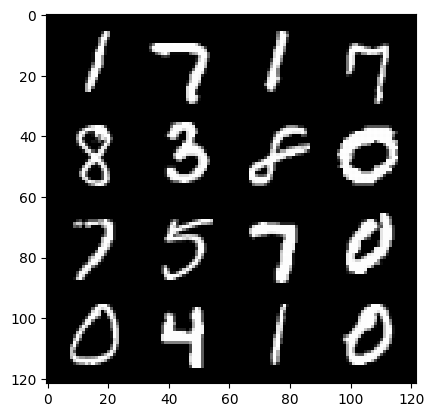

1: step 600/ Gen Loss : 0.011342747211456299/ disc_loss 0.0002596264084180196


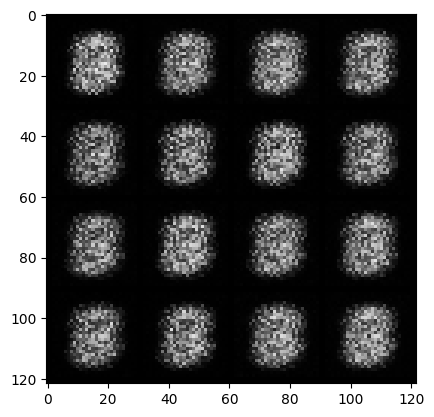

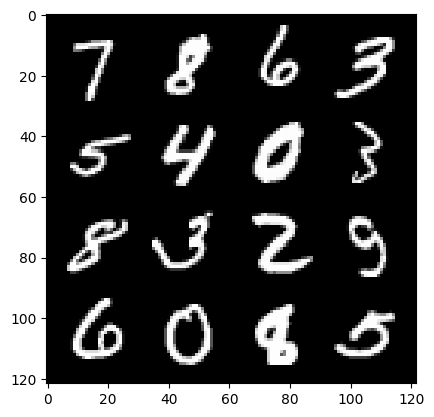

1: step 900/ Gen Loss : 0.011292199293772379/ disc_loss 0.00014144154886404673


  0%|          | 0/469 [00:00<?, ?it/s]

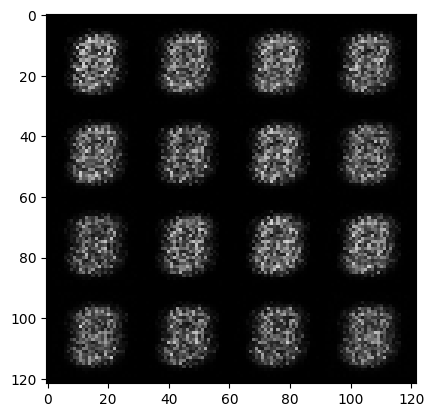

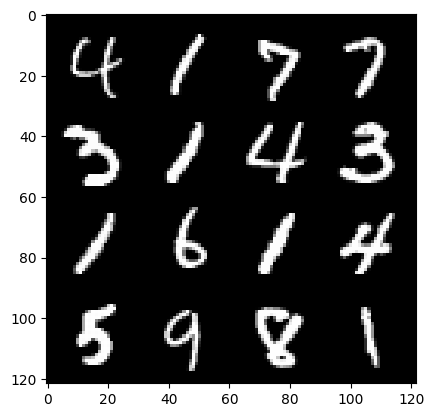

2: step 1200/ Gen Loss : 0.011573322614034017/ disc_loss 9.259004145860672e-05


  0%|          | 0/469 [00:00<?, ?it/s]

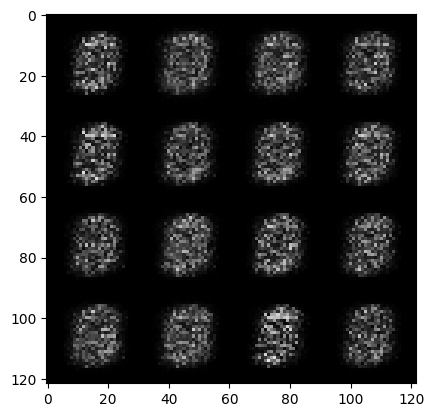

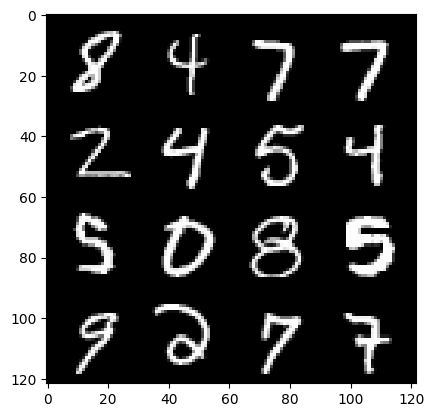

3: step 1500/ Gen Loss : 0.011022974650065104/ disc_loss 0.00014168016612529756


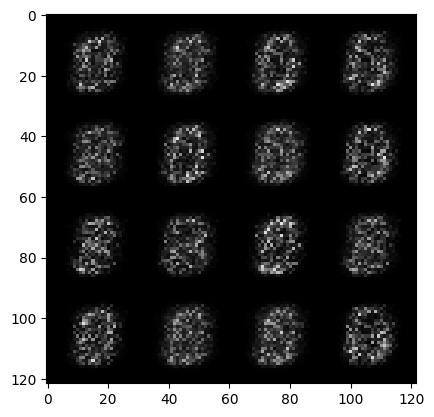

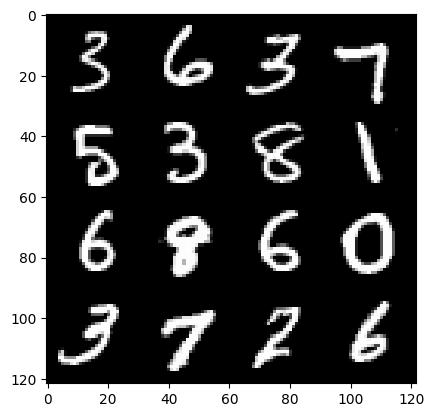

3: step 1800/ Gen Loss : 0.011737869580586752/ disc_loss 0.0001574828599890073


  0%|          | 0/469 [00:00<?, ?it/s]

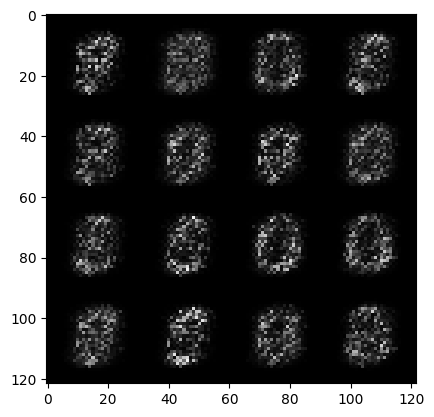

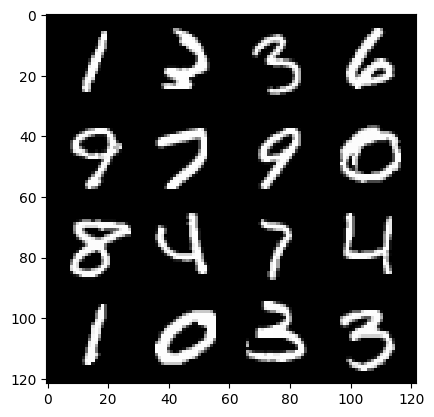

4: step 2100/ Gen Loss : 0.012136723200480143/ disc_loss 0.0001239115372300148


  0%|          | 0/469 [00:00<?, ?it/s]

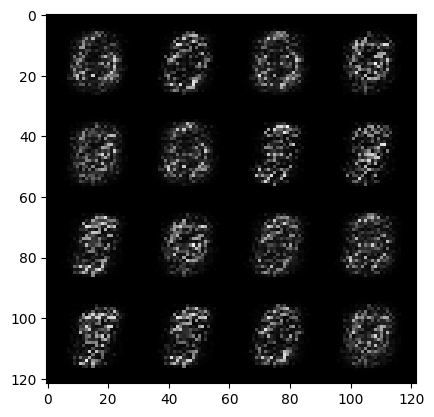

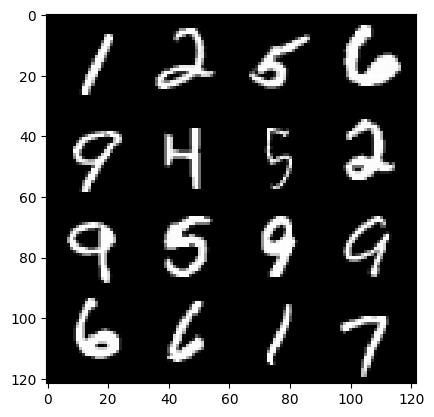

5: step 2400/ Gen Loss : 0.014463720321655273/ disc_loss 7.75406447549661e-05


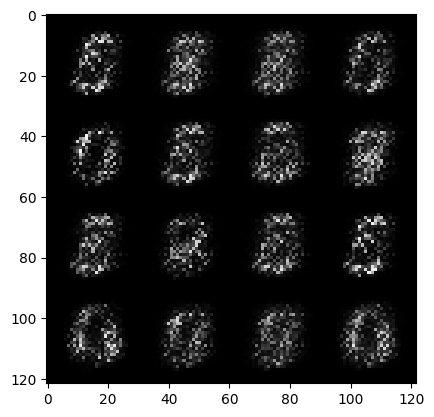

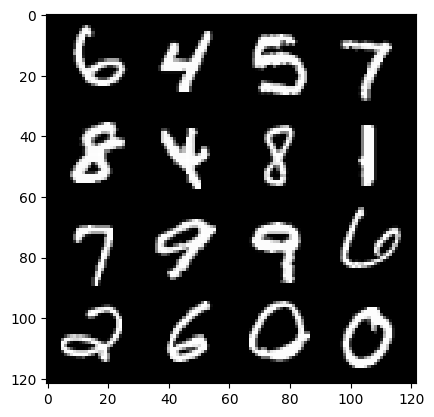

5: step 2700/ Gen Loss : 0.014308632214864095/ disc_loss 8.490962907671929e-05


  0%|          | 0/469 [00:00<?, ?it/s]

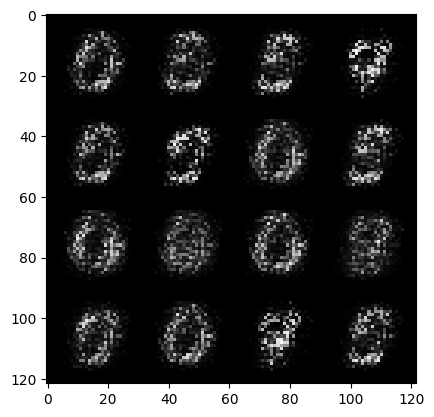

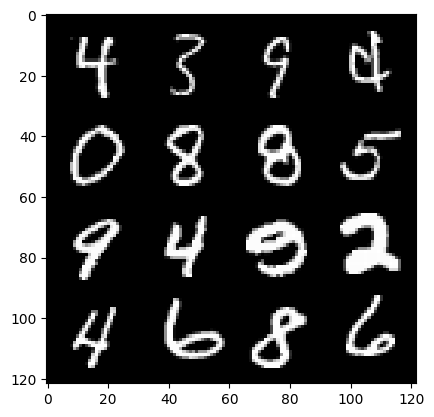

6: step 3000/ Gen Loss : 0.01529072125752767/ disc_loss 8.160042266050975e-05


  0%|          | 0/469 [00:00<?, ?it/s]

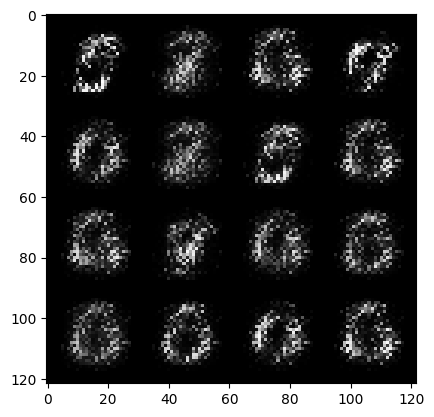

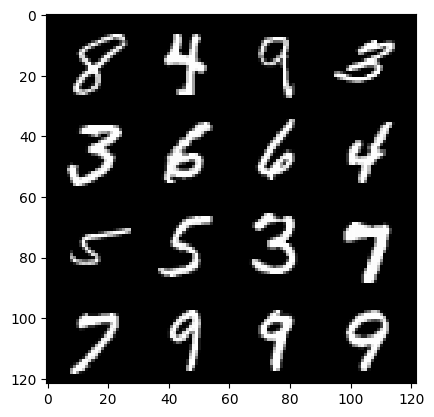

7: step 3300/ Gen Loss : 0.016585070292154946/ disc_loss 5.201683690150579e-05


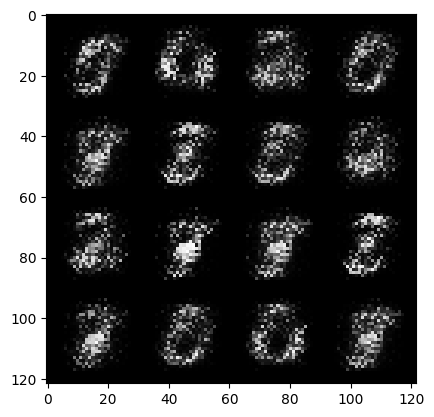

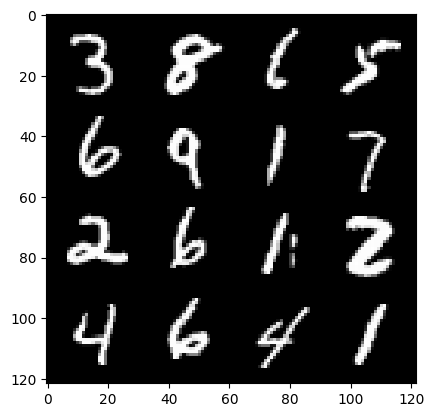

7: step 3600/ Gen Loss : 0.01787183125813802/ disc_loss 7.293036828438442e-05


  0%|          | 0/469 [00:00<?, ?it/s]

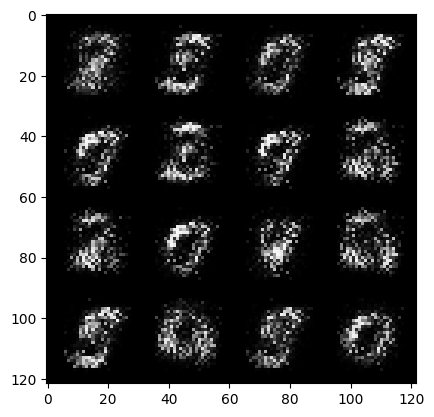

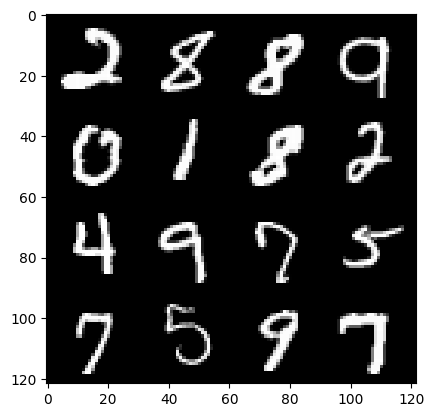

8: step 3900/ Gen Loss : 0.017143770853678384/ disc_loss 7.116582865516345e-05


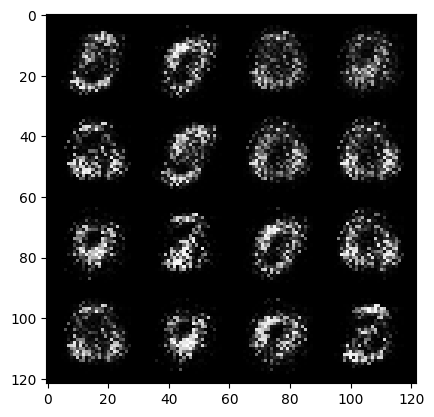

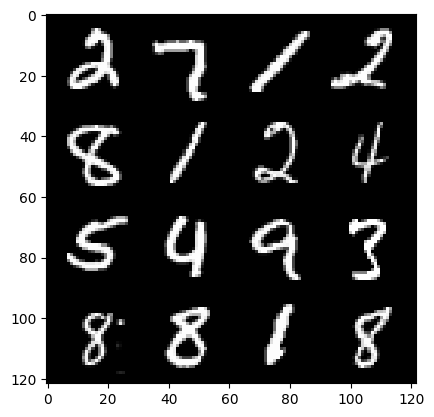

8: step 4200/ Gen Loss : 0.019061779975891112/ disc_loss 3.498026169836521e-05


  0%|          | 0/469 [00:00<?, ?it/s]

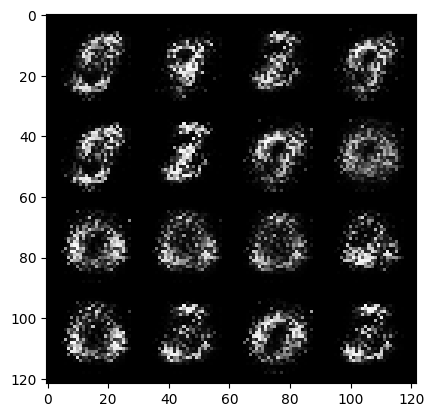

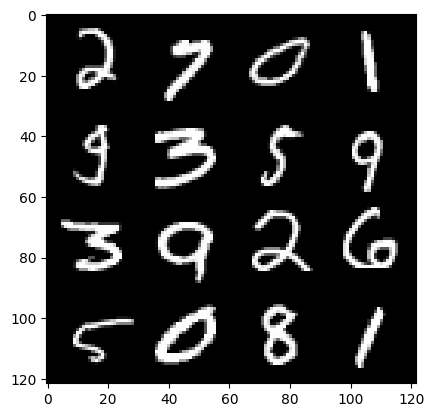

9: step 4500/ Gen Loss : 0.019650036493937175/ disc_loss 2.5367330138882e-05


  0%|          | 0/469 [00:00<?, ?it/s]

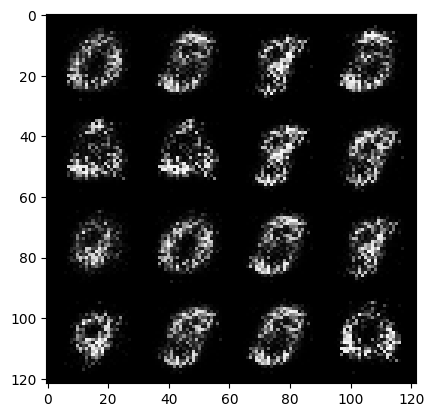

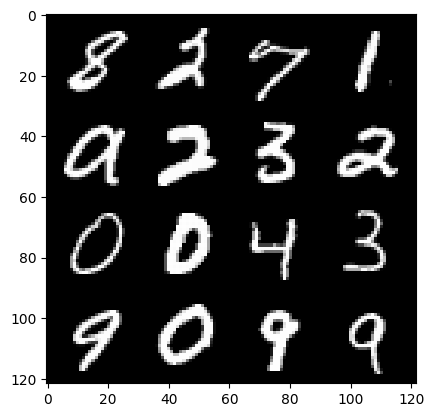

10: step 4800/ Gen Loss : 0.019973150889078774/ disc_loss 2.0360190731783708e-05


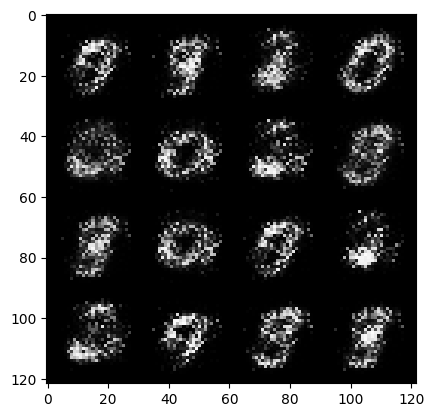

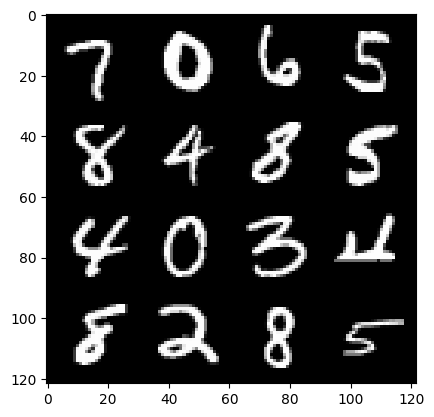

10: step 5100/ Gen Loss : 0.02049010753631592/ disc_loss 2.3676818236708642e-05


  0%|          | 0/469 [00:00<?, ?it/s]

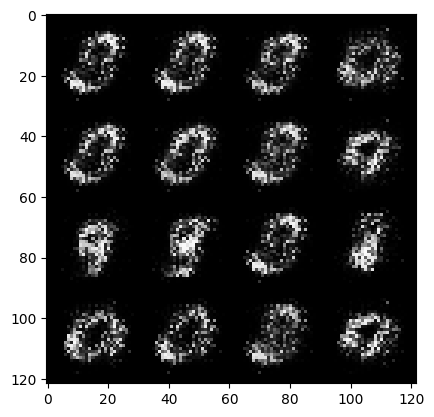

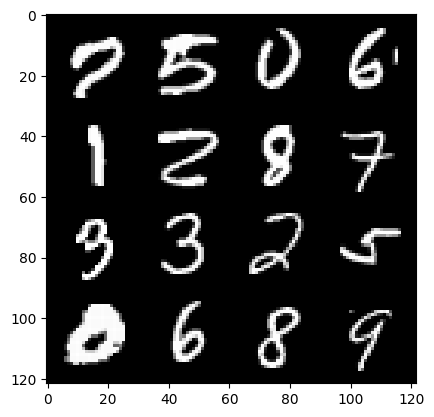

11: step 5400/ Gen Loss : 0.021990243593851724/ disc_loss 3.1711161136627196e-05


  0%|          | 0/469 [00:00<?, ?it/s]

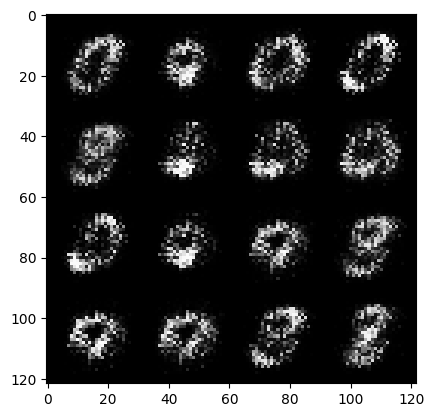

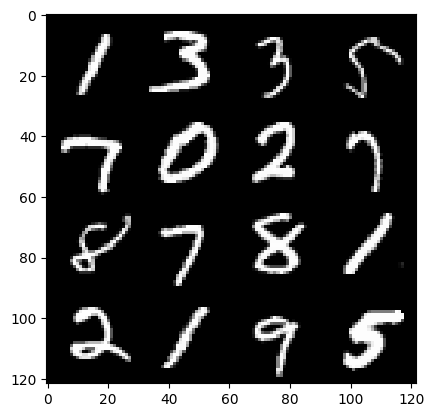

12: step 5700/ Gen Loss : 0.02155492941538493/ disc_loss 5.510206644733747e-05


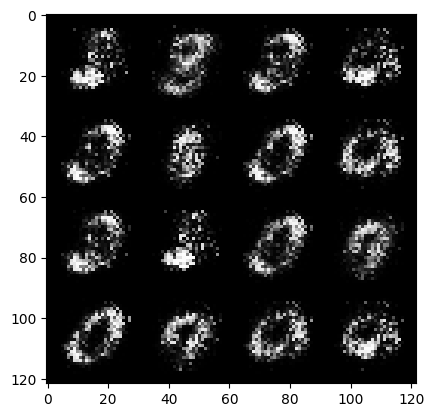

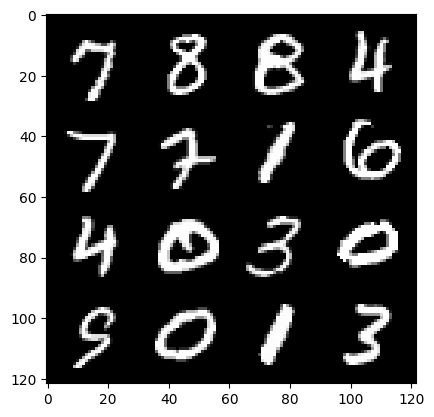

12: step 6000/ Gen Loss : 0.022689396540323894/ disc_loss 1.95674163599809e-05


  0%|          | 0/469 [00:00<?, ?it/s]

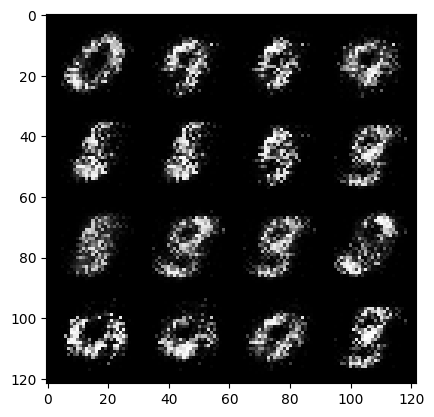

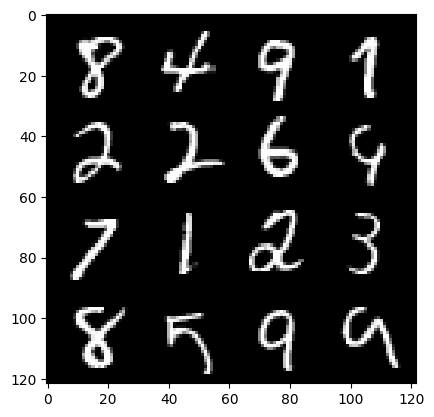

13: step 6300/ Gen Loss : 0.019677549997965494/ disc_loss 3.8185128942132e-05


  0%|          | 0/469 [00:00<?, ?it/s]

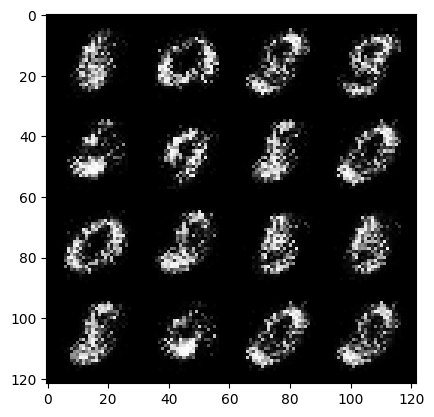

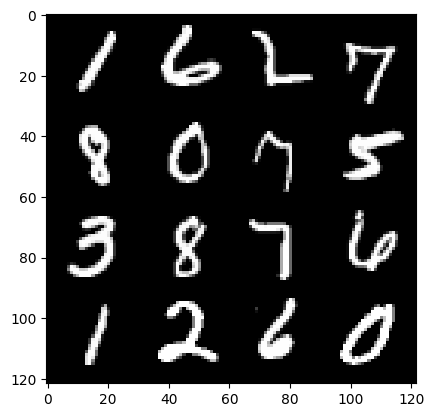

14: step 6600/ Gen Loss : 0.021476718584696453/ disc_loss 1.5896144323050975e-05


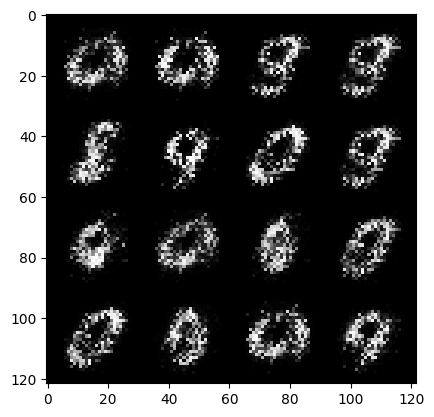

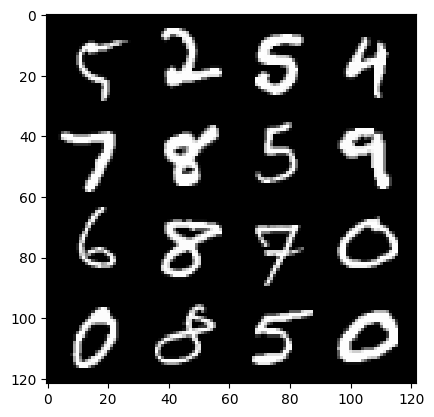

14: step 6900/ Gen Loss : 0.02621622403462728/ disc_loss 2.9540928080677988e-05


  0%|          | 0/469 [00:00<?, ?it/s]

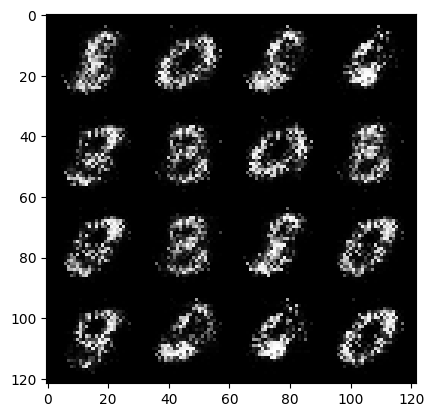

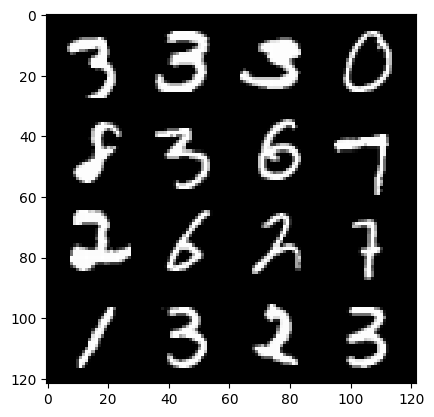

15: step 7200/ Gen Loss : 0.023537174860636393/ disc_loss 2.18522222712636e-05


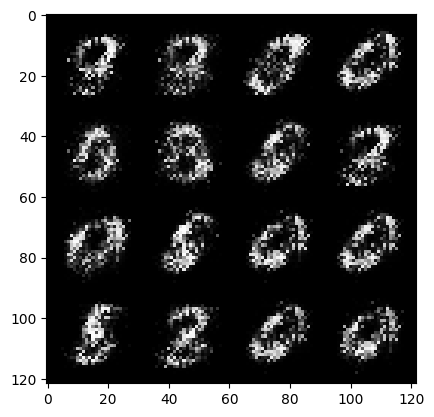

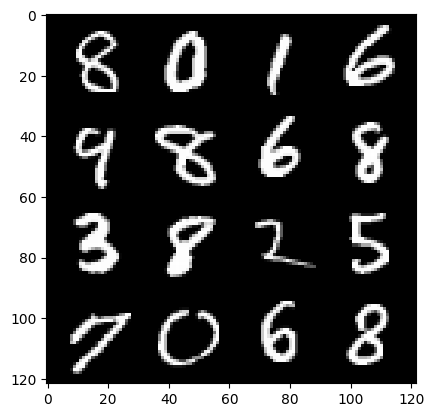

15: step 7500/ Gen Loss : 0.023443571726481118/ disc_loss 3.2524503767490385e-05


  0%|          | 0/469 [00:00<?, ?it/s]

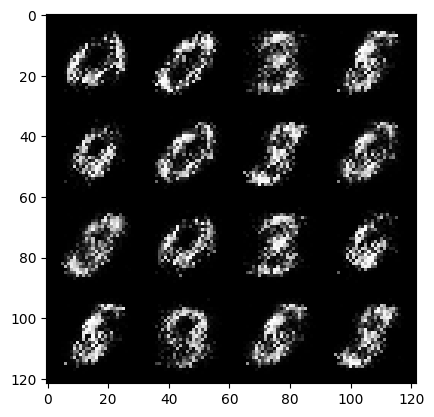

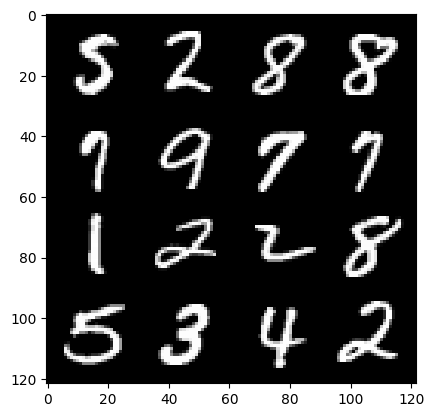

16: step 7800/ Gen Loss : 0.023743537267049152/ disc_loss 2.3725382052361966e-05


  0%|          | 0/469 [00:00<?, ?it/s]

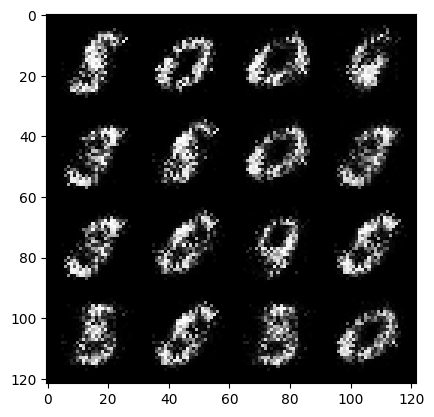

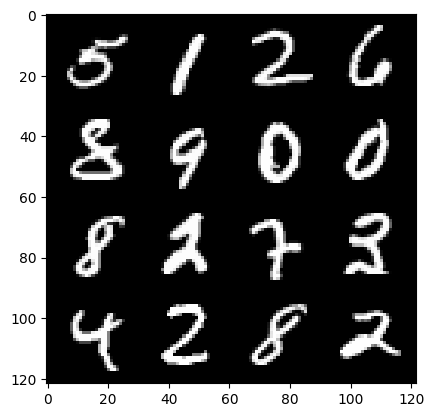

17: step 8100/ Gen Loss : 0.02073223114013672/ disc_loss 7.329034308592478e-05


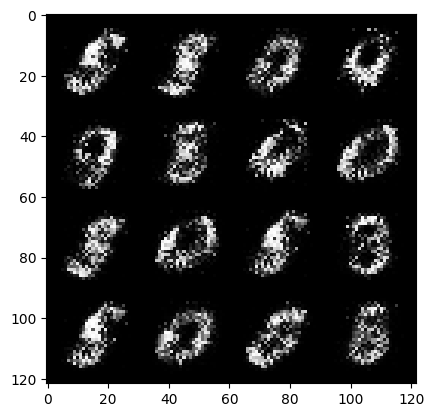

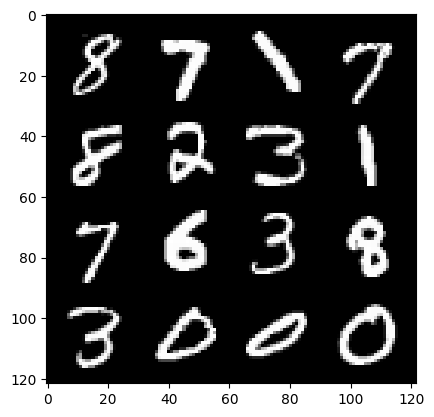

17: step 8400/ Gen Loss : 0.021583038965861/ disc_loss 1.9191304842631023e-05


  0%|          | 0/469 [00:00<?, ?it/s]

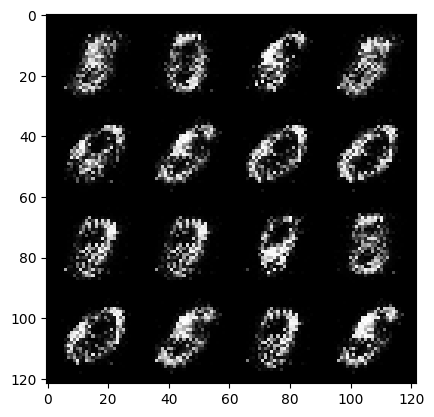

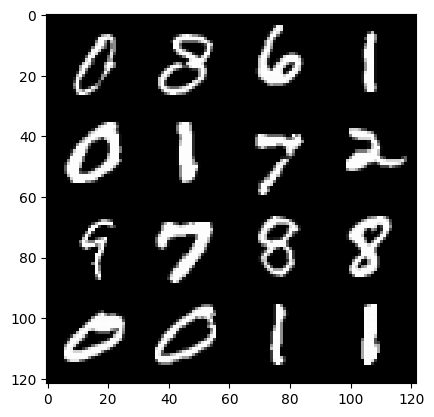

18: step 8700/ Gen Loss : 0.021727291742960612/ disc_loss 4.585458276172479e-05


  0%|          | 0/469 [00:00<?, ?it/s]

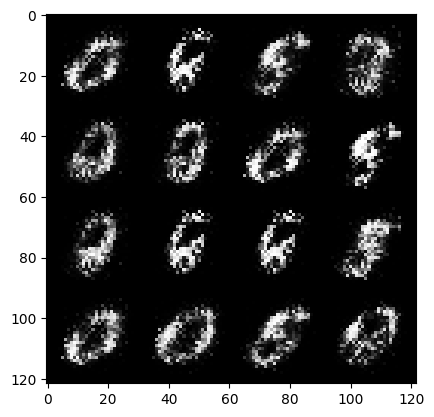

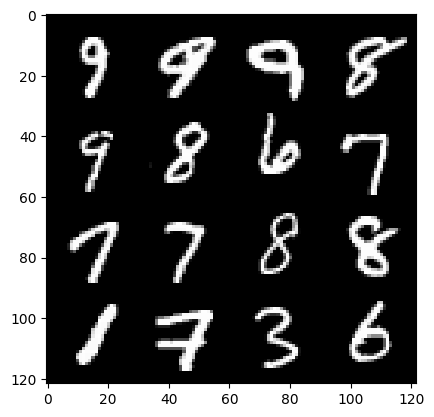

19: step 9000/ Gen Loss : 0.026089436213175457/ disc_loss 2.6080297927061718e-05


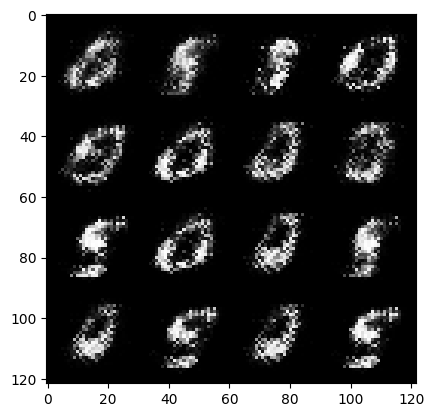

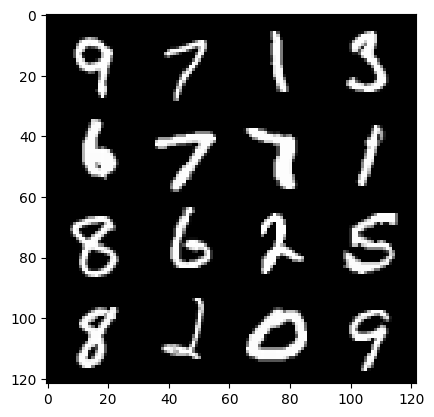

19: step 9300/ Gen Loss : 0.021614452997843425/ disc_loss 5.106850837667783e-05


  0%|          | 0/469 [00:00<?, ?it/s]

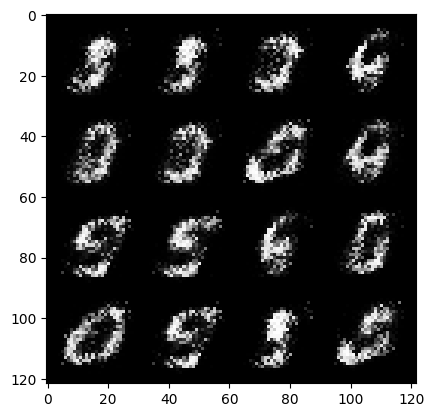

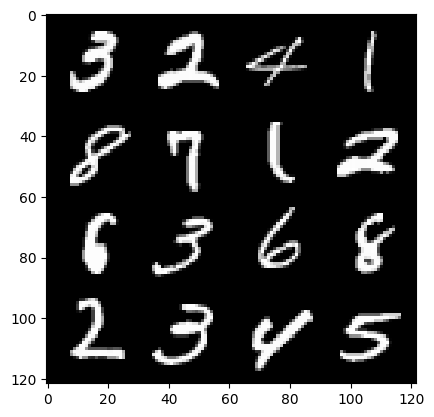

20: step 9600/ Gen Loss : 0.02296189626057943/ disc_loss 6.419421484073003e-05


  0%|          | 0/469 [00:00<?, ?it/s]

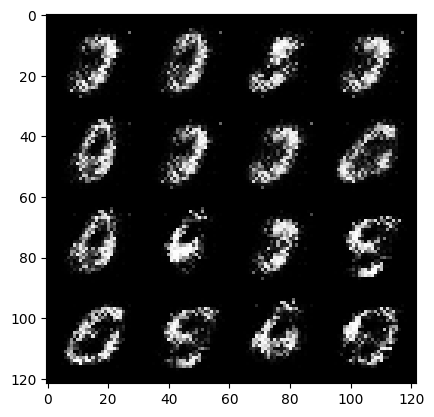

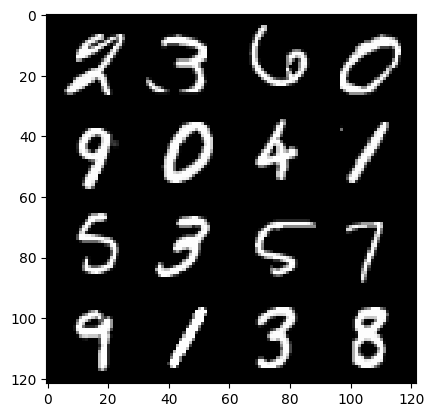

21: step 9900/ Gen Loss : 0.02236861228942871/ disc_loss 2.8386227786540985e-05


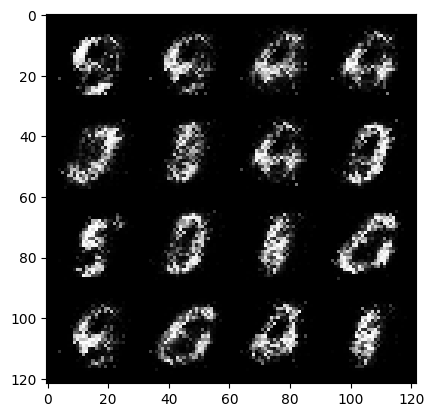

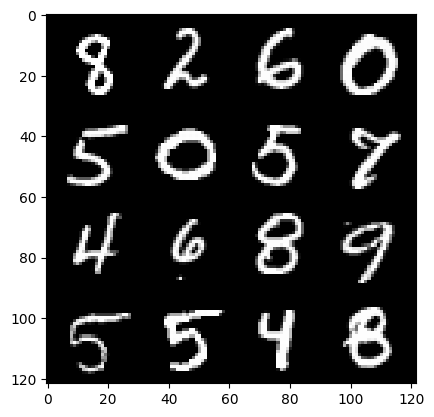

21: step 10200/ Gen Loss : 0.019430742263793946/ disc_loss 5.996178835630417e-05


  0%|          | 0/469 [00:00<?, ?it/s]

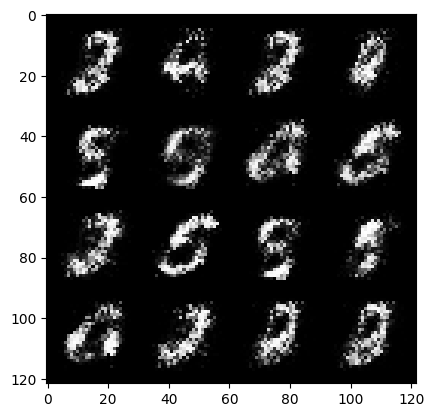

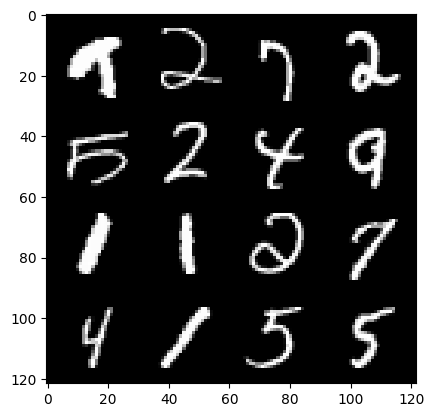

22: step 10500/ Gen Loss : 0.024776201248168945/ disc_loss 5.317801609635353e-05


  0%|          | 0/469 [00:00<?, ?it/s]

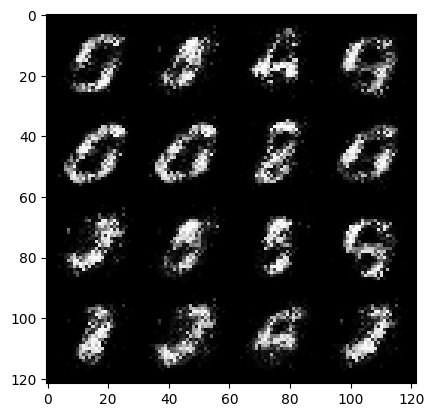

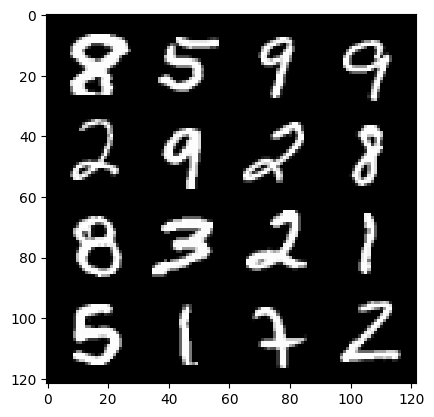

23: step 10800/ Gen Loss : 0.022708606719970704/ disc_loss 2.195036349197229e-05


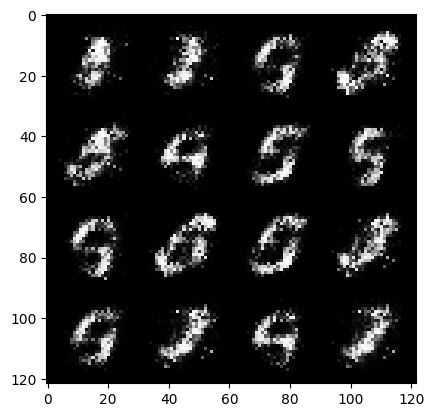

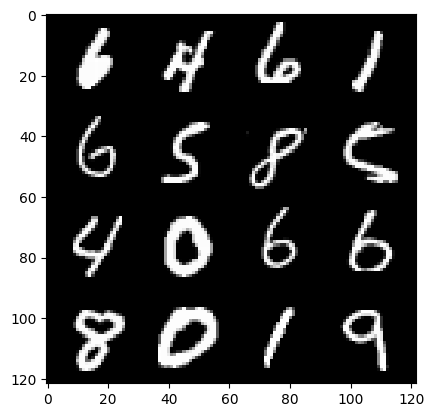

23: step 11100/ Gen Loss : 0.02345500946044922/ disc_loss 1.6474655518929165e-05


  0%|          | 0/469 [00:00<?, ?it/s]

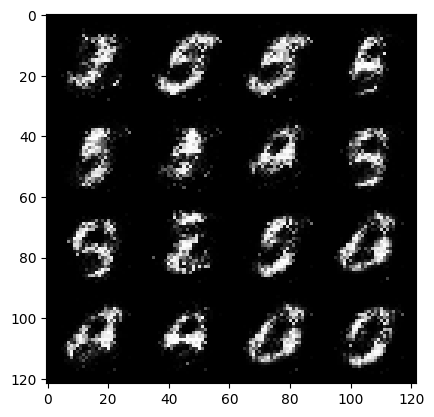

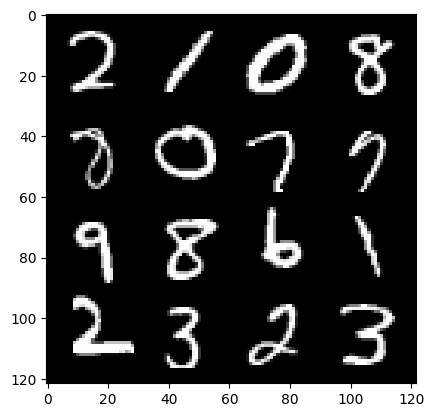

24: step 11400/ Gen Loss : 0.021793432235717773/ disc_loss 3.333903849124908e-05


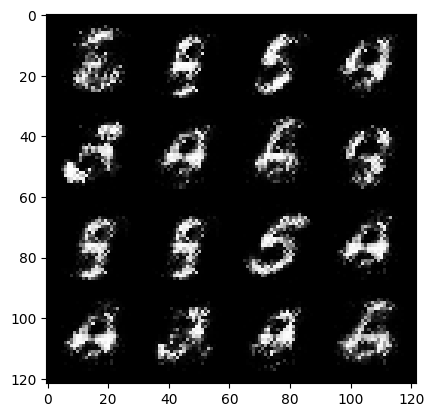

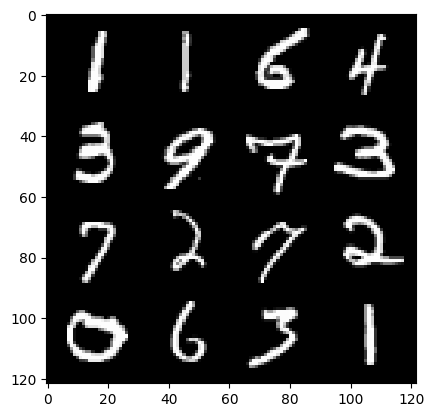

24: step 11700/ Gen Loss : 0.02174578348795573/ disc_loss 4.8078233376145363e-05


  0%|          | 0/469 [00:00<?, ?it/s]

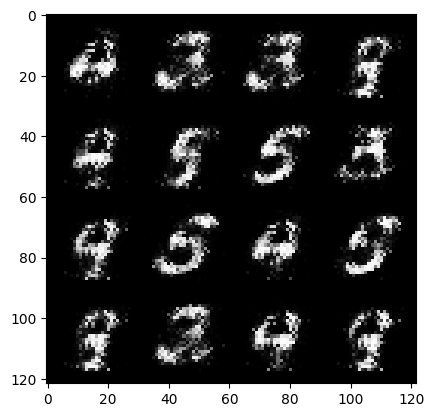

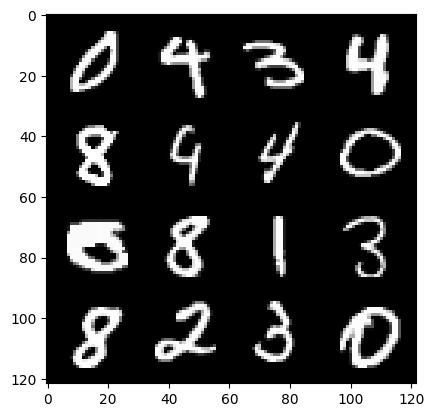

25: step 12000/ Gen Loss : 0.019189327557881674/ disc_loss 4.1703240325053535e-05


  0%|          | 0/469 [00:00<?, ?it/s]

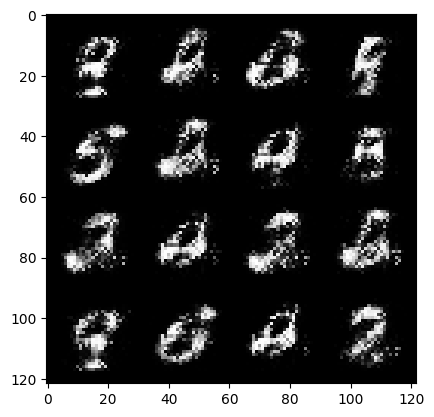

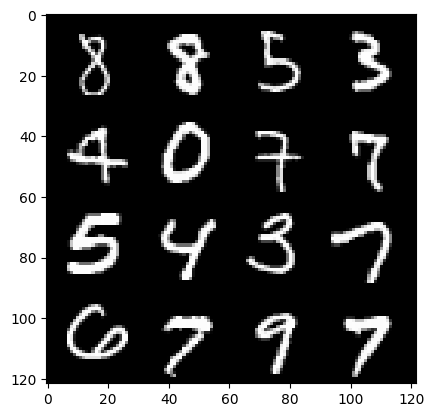

26: step 12300/ Gen Loss : 0.020176153182983398/ disc_loss 5.1966719329357144e-05


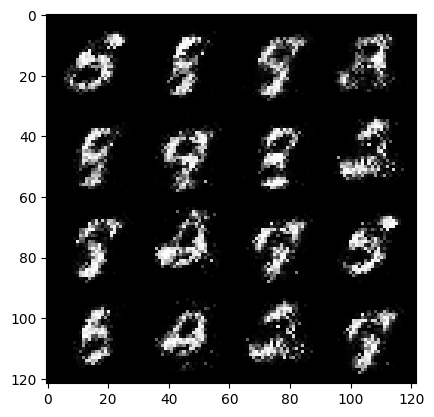

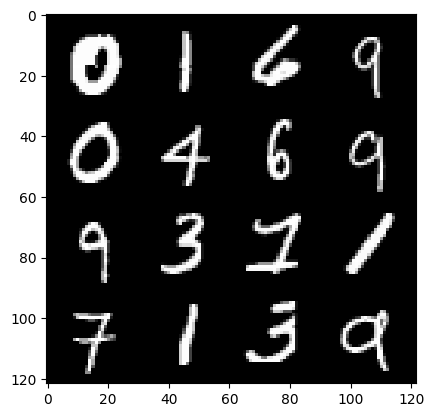

26: step 12600/ Gen Loss : 0.025837806065877277/ disc_loss 1.081130001693964e-05


  0%|          | 0/469 [00:00<?, ?it/s]

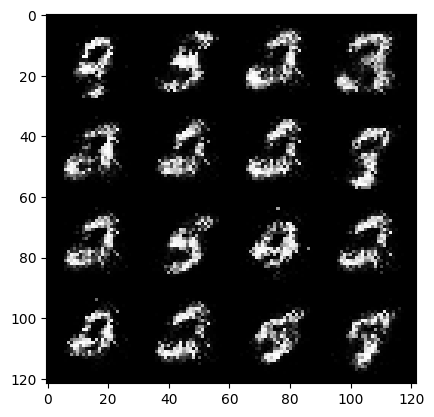

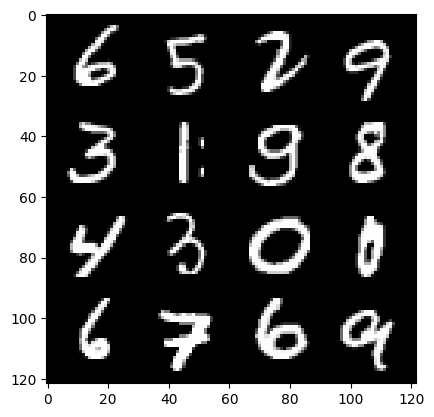

27: step 12900/ Gen Loss : 0.023280242284138997/ disc_loss 0.00011403719584147136


  0%|          | 0/469 [00:00<?, ?it/s]

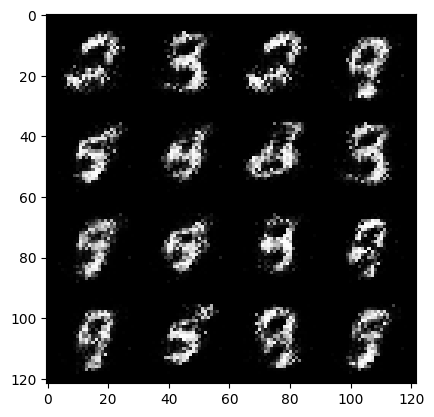

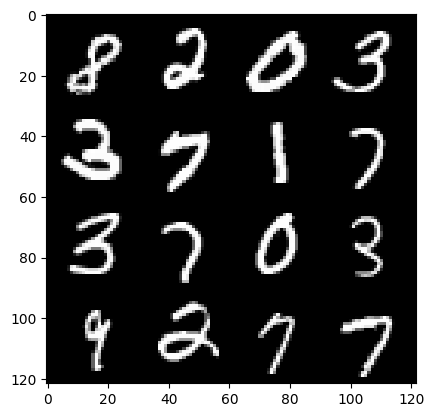

28: step 13200/ Gen Loss : 0.02388317584991455/ disc_loss 4.033641889691353e-05


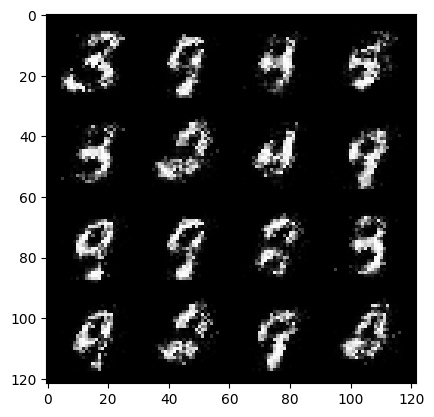

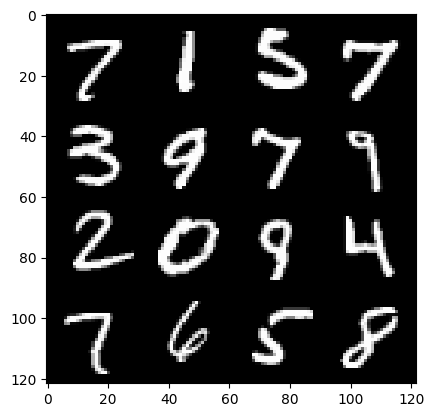

28: step 13500/ Gen Loss : 0.023126921653747558/ disc_loss 9.565134222308794e-05


  0%|          | 0/469 [00:00<?, ?it/s]

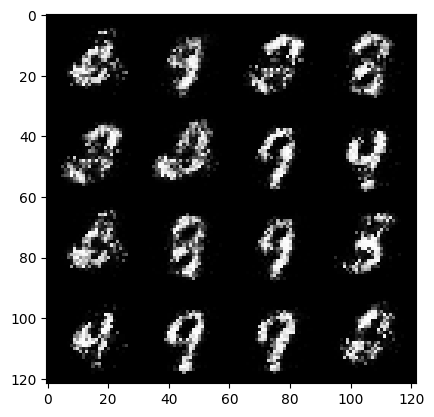

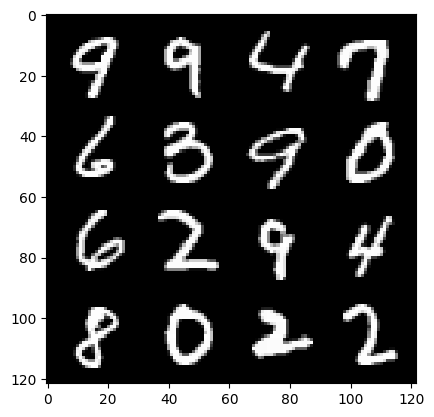

29: step 13800/ Gen Loss : 0.022291345596313475/ disc_loss 2.658367156982422e-05


  0%|          | 0/469 [00:00<?, ?it/s]

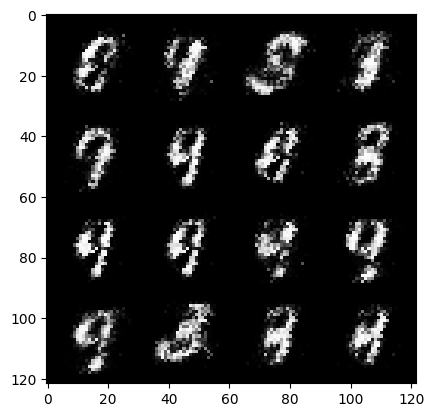

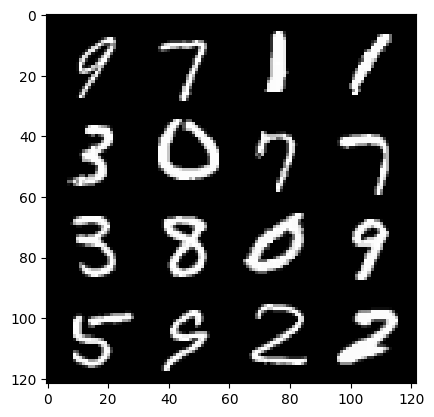

30: step 14100/ Gen Loss : 0.023676185607910155/ disc_loss 4.492463544011116e-05


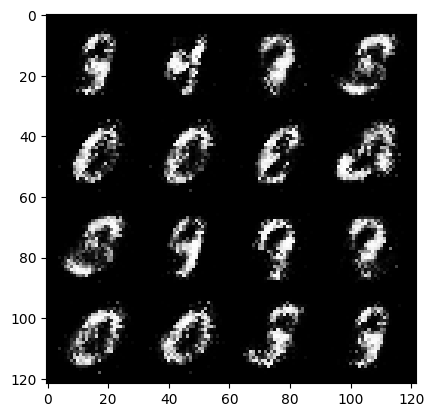

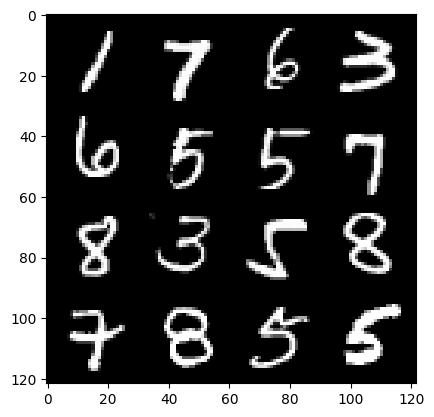

30: step 14400/ Gen Loss : 0.017794628143310547/ disc_loss 0.00015772625803947449


  0%|          | 0/469 [00:00<?, ?it/s]

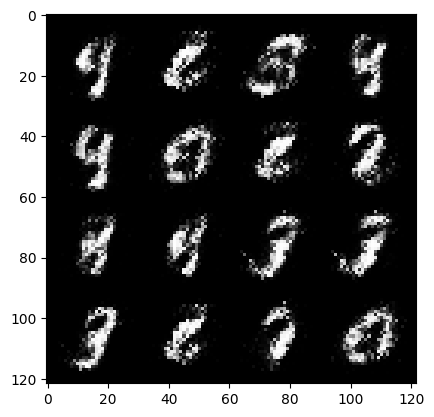

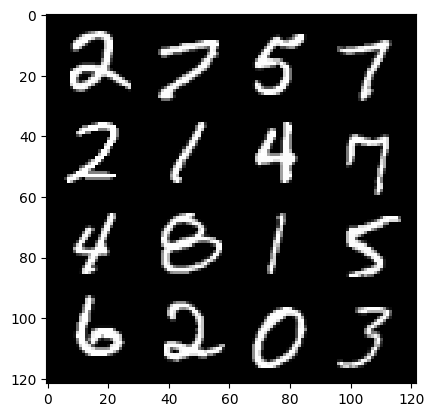

31: step 14700/ Gen Loss : 0.0199654754002889/ disc_loss 4.0656647955377895e-05


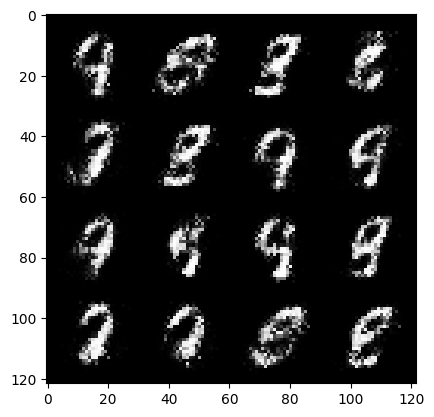

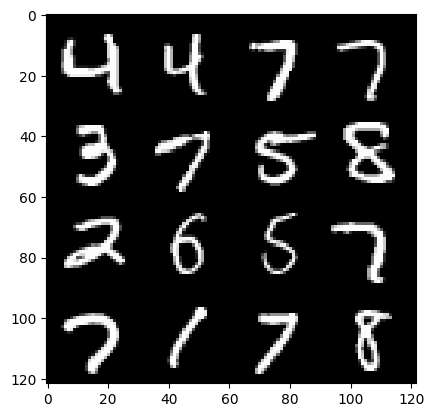

31: step 15000/ Gen Loss : 0.020717067718505858/ disc_loss 5.901596198479335e-05


  0%|          | 0/469 [00:00<?, ?it/s]

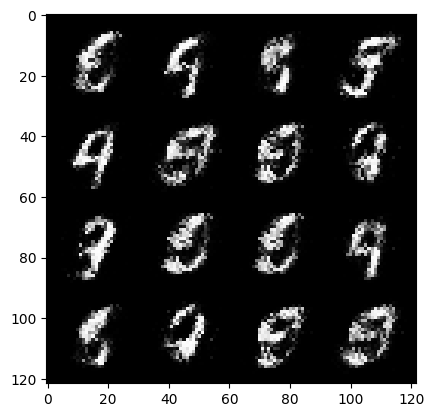

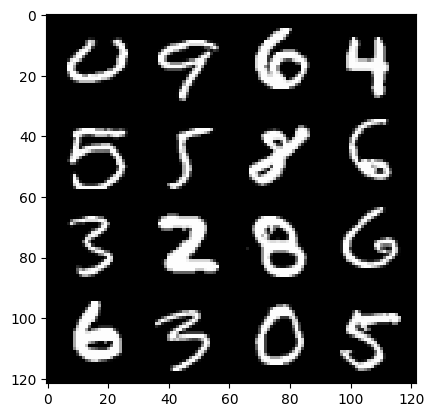

32: step 15300/ Gen Loss : 0.01882757822672526/ disc_loss 5.143292558689912e-05


  0%|          | 0/469 [00:00<?, ?it/s]

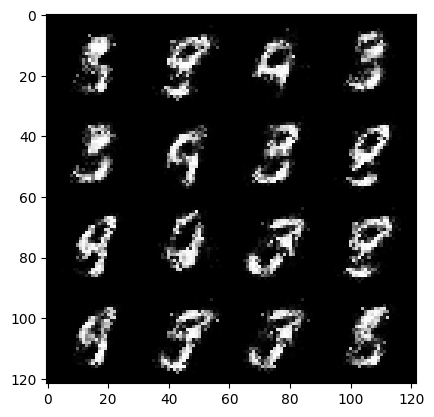

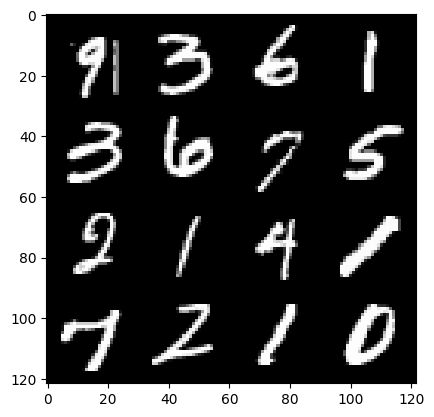

33: step 15600/ Gen Loss : 0.019856052398681642/ disc_loss 8.881850788990657e-05


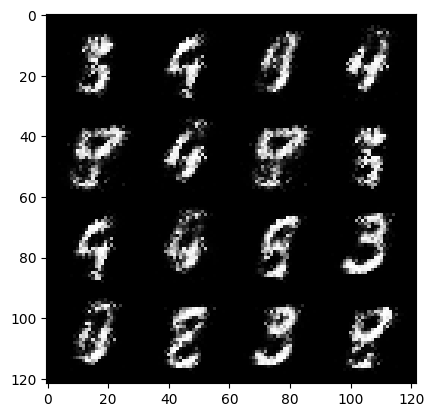

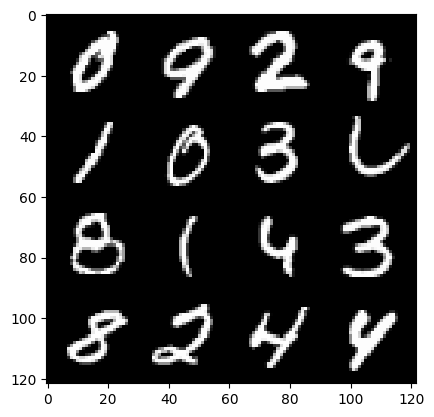

33: step 15900/ Gen Loss : 0.022028031349182128/ disc_loss 5.329169953862826e-05


  0%|          | 0/469 [00:00<?, ?it/s]

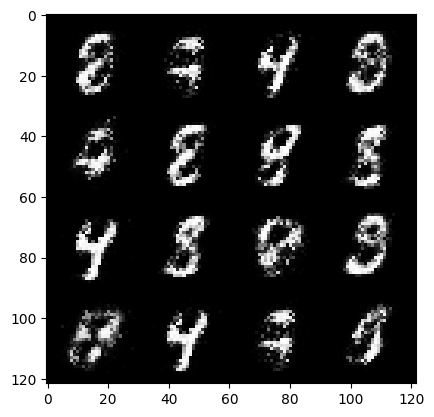

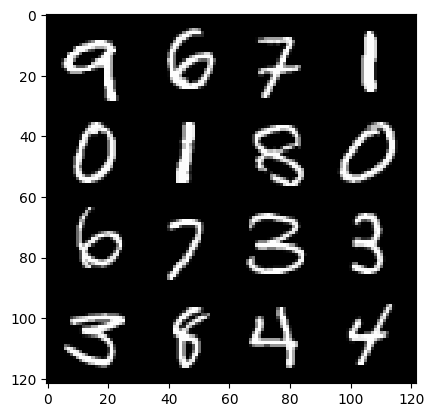

34: step 16200/ Gen Loss : 0.019080985387166342/ disc_loss 9.637763102849324e-05


  0%|          | 0/469 [00:00<?, ?it/s]

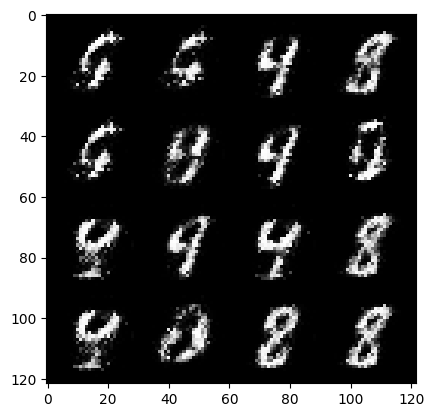

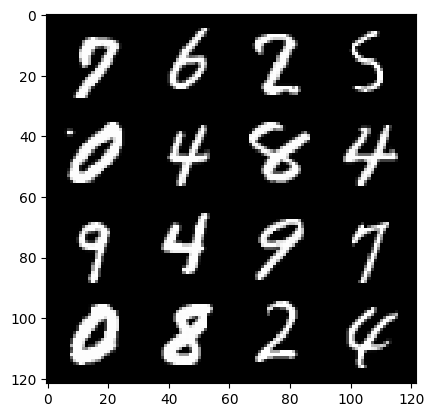

35: step 16500/ Gen Loss : 0.020017944971720377/ disc_loss 8.744567632675171e-05


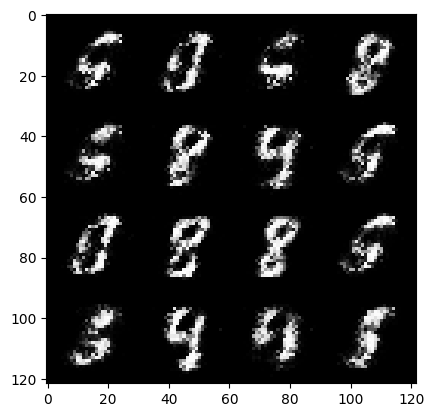

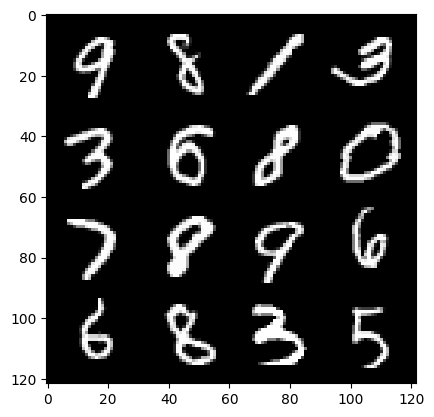

35: step 16800/ Gen Loss : 0.01948022206624349/ disc_loss 0.00013312601794799168


  0%|          | 0/469 [00:00<?, ?it/s]

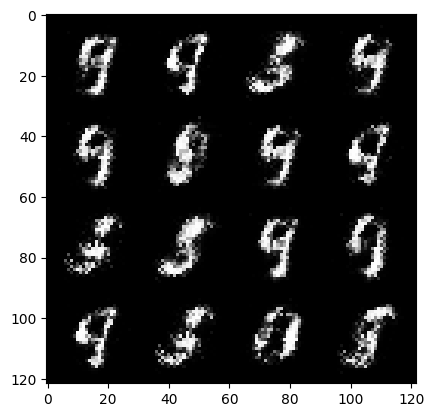

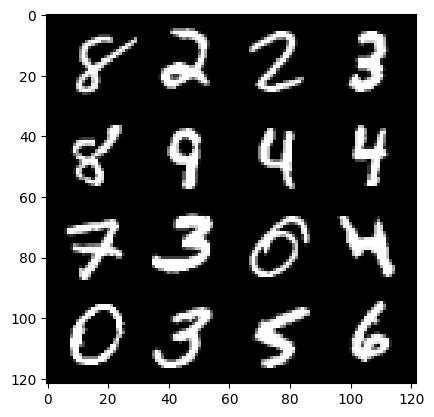

36: step 17100/ Gen Loss : 0.02220576604207357/ disc_loss 9.819166734814644e-05


  0%|          | 0/469 [00:00<?, ?it/s]

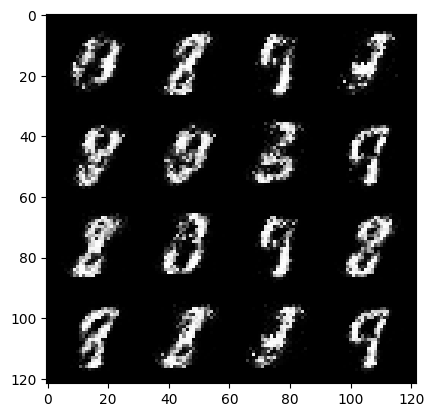

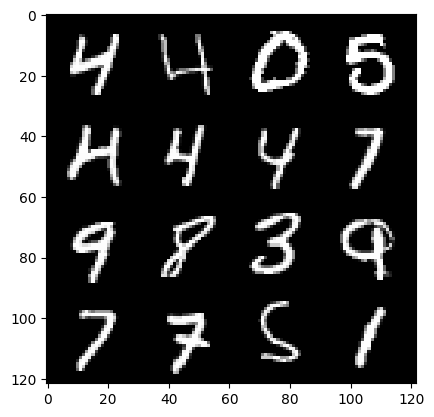

37: step 17400/ Gen Loss : 0.02088716983795166/ disc_loss 8.030475427707036e-05


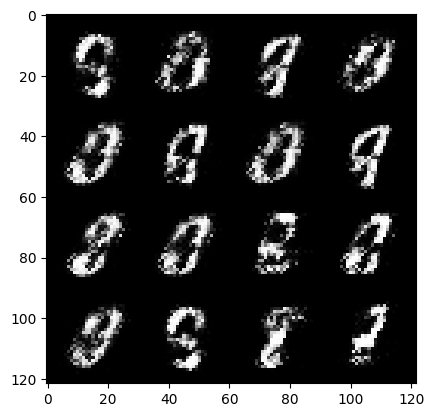

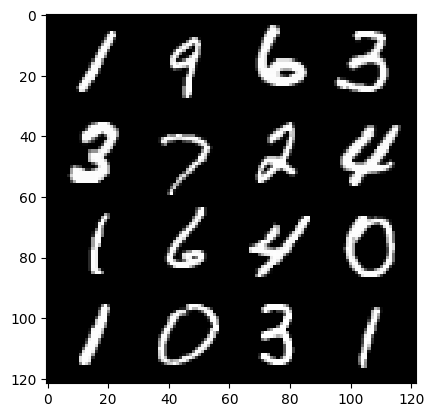

37: step 17700/ Gen Loss : 0.018400980631510418/ disc_loss 0.00010414423421025277


  0%|          | 0/469 [00:00<?, ?it/s]

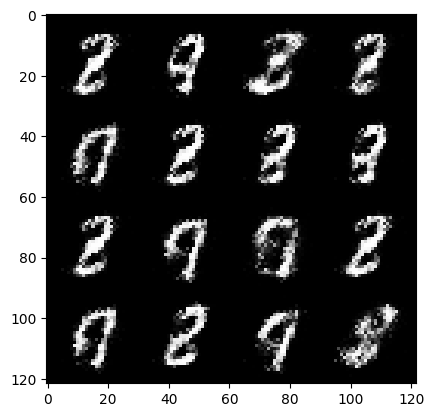

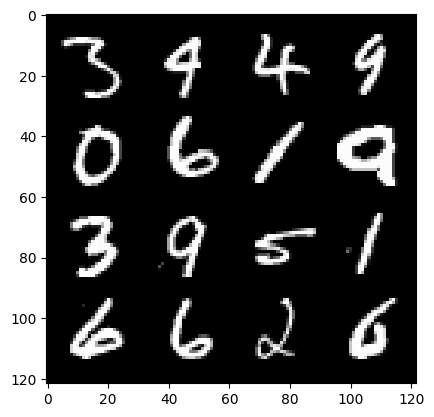

38: step 18000/ Gen Loss : 0.018000427881876627/ disc_loss 0.00014623389889796575


  0%|          | 0/469 [00:00<?, ?it/s]

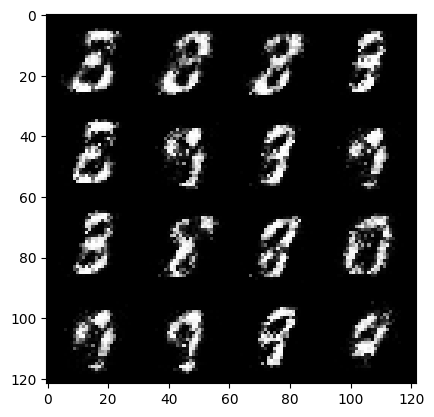

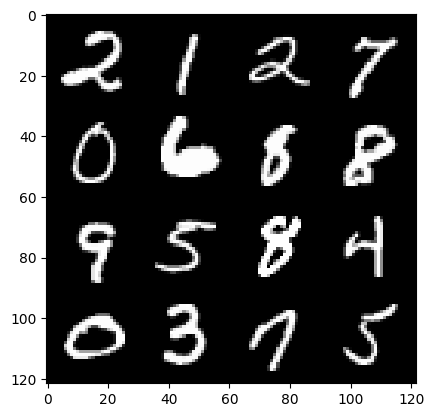

39: step 18300/ Gen Loss : 0.020214179356892903/ disc_loss 0.0001357983301083247


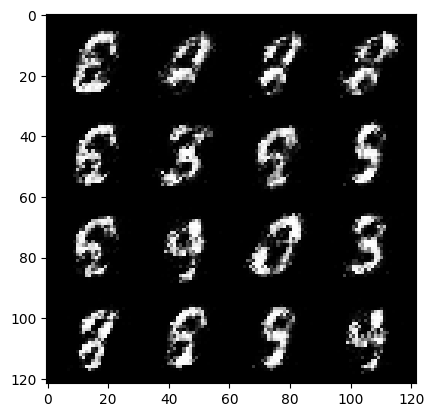

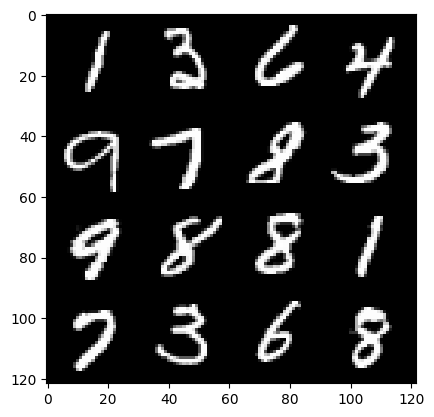

39: step 18600/ Gen Loss : 0.020083160400390626/ disc_loss 0.0001564556360244751


  0%|          | 0/469 [00:00<?, ?it/s]

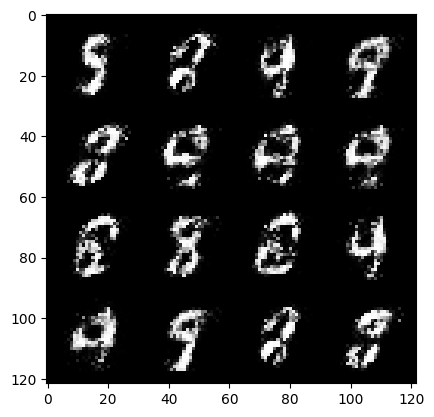

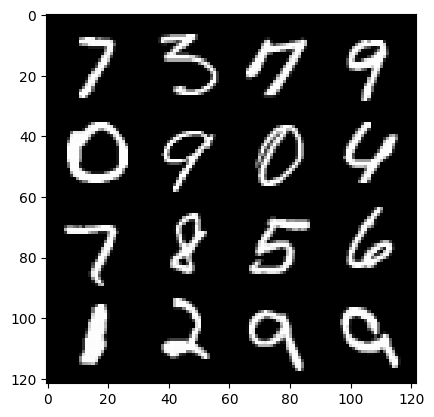

40: step 18900/ Gen Loss : 0.018918628692626952/ disc_loss 0.00014713242650032043


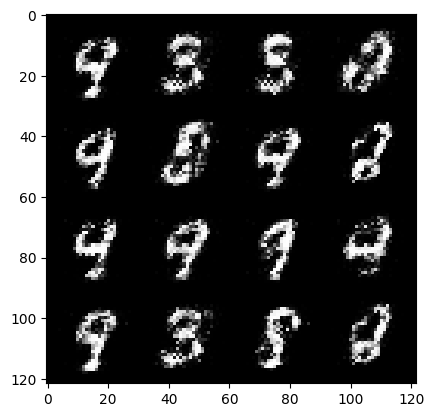

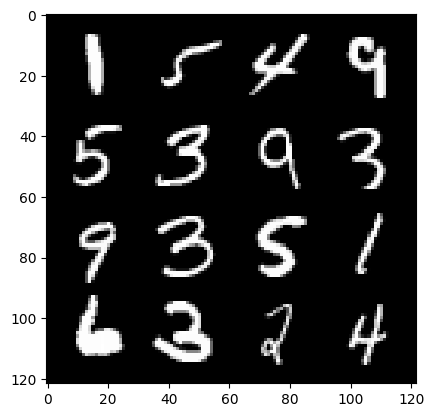

40: step 19200/ Gen Loss : 0.01809263865152995/ disc_loss 0.00018012712399164836


  0%|          | 0/469 [00:00<?, ?it/s]

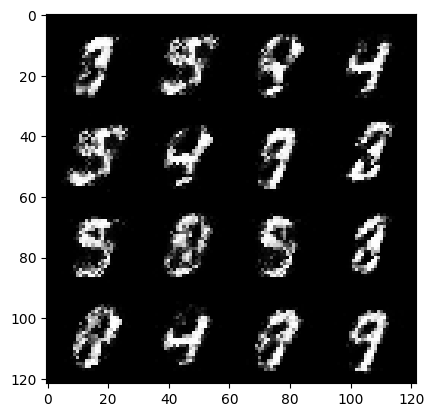

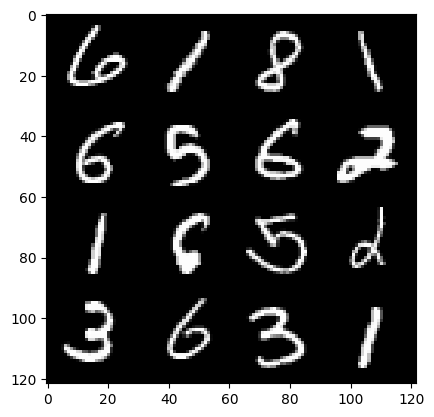

41: step 19500/ Gen Loss : 0.019295323689778647/ disc_loss 0.00010147842889030774


  0%|          | 0/469 [00:00<?, ?it/s]

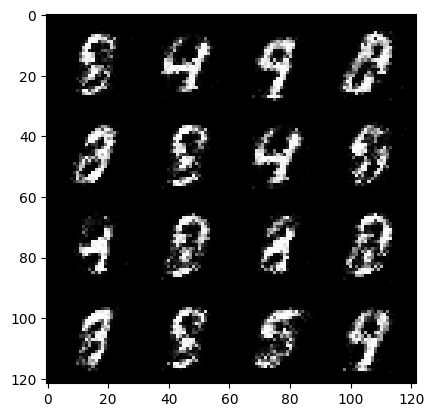

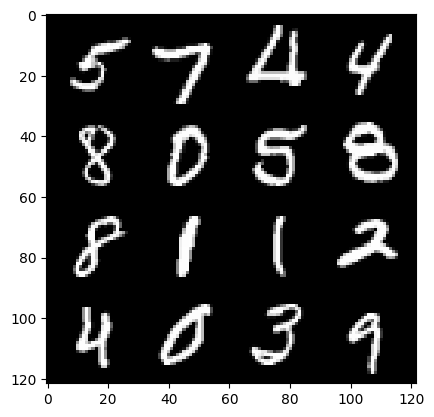

42: step 19800/ Gen Loss : 0.017843613624572752/ disc_loss 6.082378327846527e-05


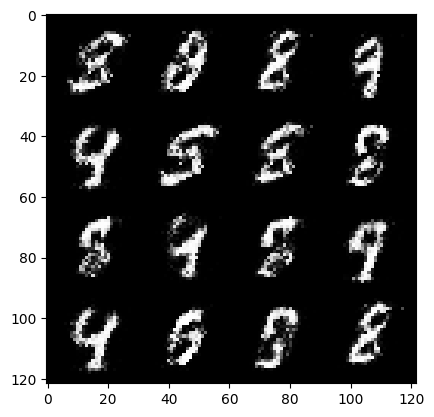

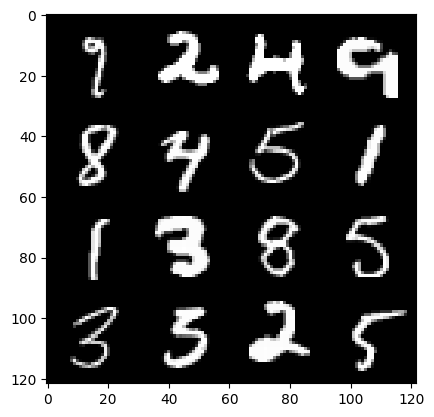

42: step 20100/ Gen Loss : 0.019375025431315106/ disc_loss 0.00031392820179462435


  0%|          | 0/469 [00:00<?, ?it/s]

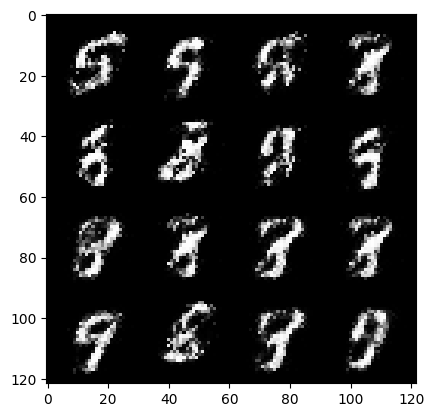

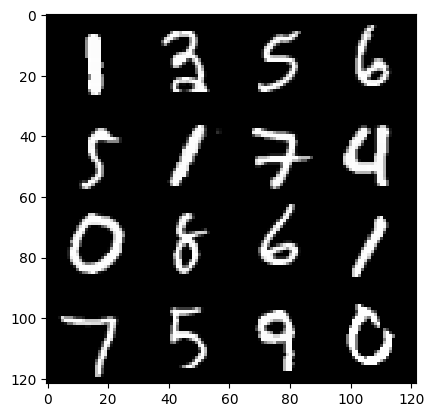

43: step 20400/ Gen Loss : 0.02335666020711263/ disc_loss 0.00011921487748622894


  0%|          | 0/469 [00:00<?, ?it/s]

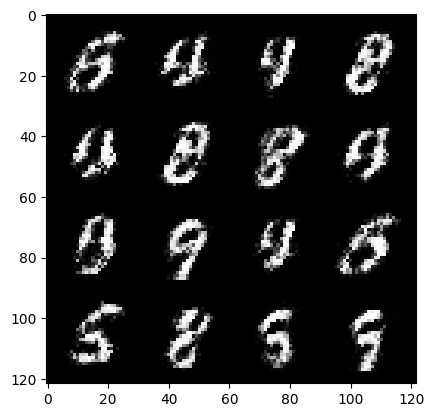

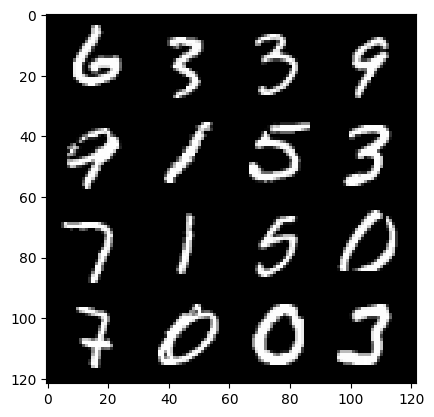

44: step 20700/ Gen Loss : 0.018853524525960286/ disc_loss 0.00014583644767602284


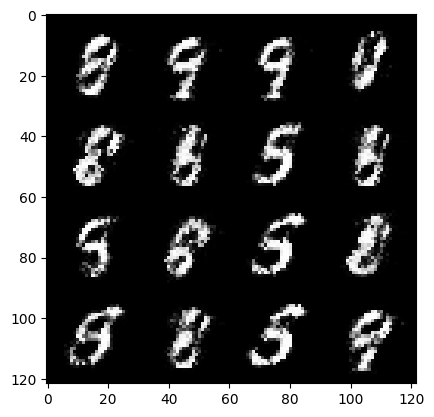

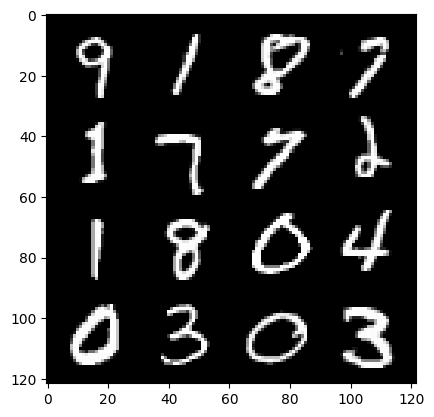

44: step 21000/ Gen Loss : 0.01766864776611328/ disc_loss 8.089336877067884e-05


  0%|          | 0/469 [00:00<?, ?it/s]

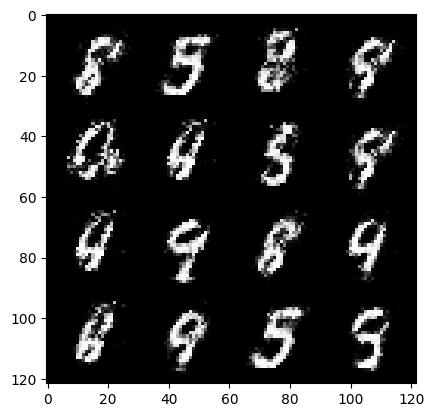

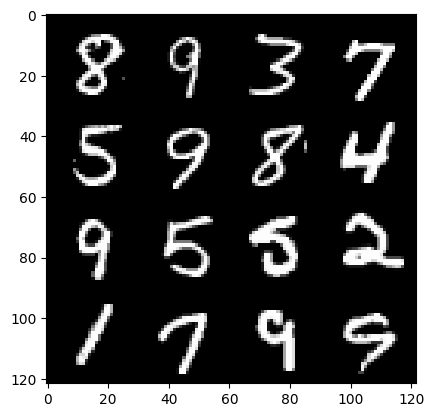

45: step 21300/ Gen Loss : 0.016935348510742188/ disc_loss 0.0004726862410704295


  0%|          | 0/469 [00:00<?, ?it/s]

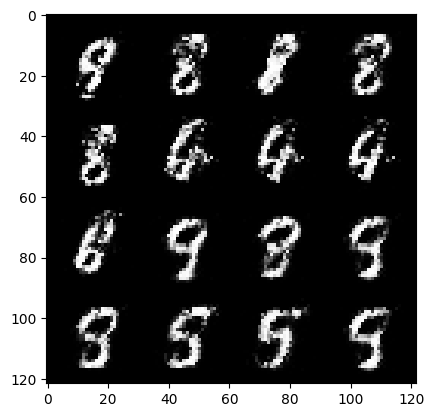

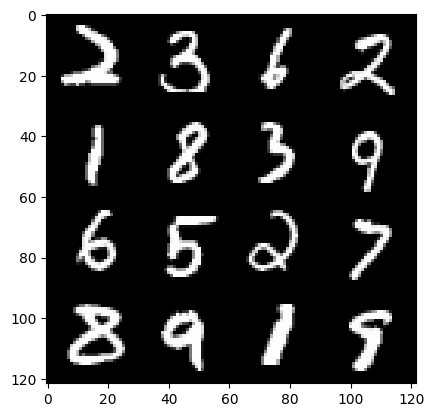

46: step 21600/ Gen Loss : 0.016077418327331543/ disc_loss 8.87662669022878e-05


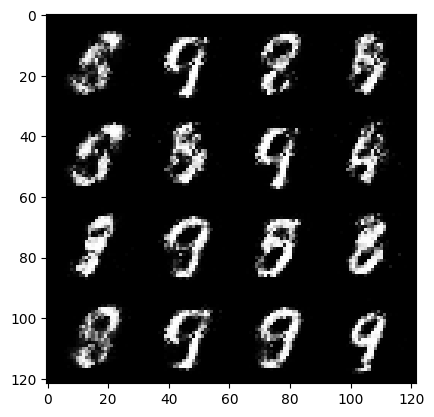

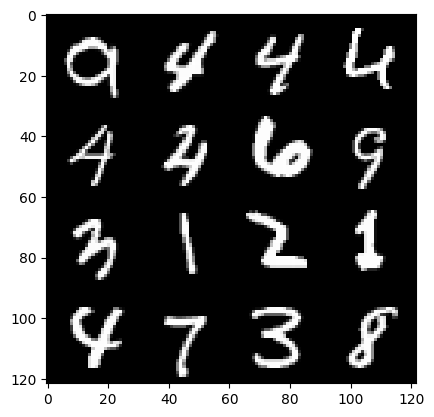

46: step 21900/ Gen Loss : 0.018832610448201496/ disc_loss 0.00031837264696757


  0%|          | 0/469 [00:00<?, ?it/s]

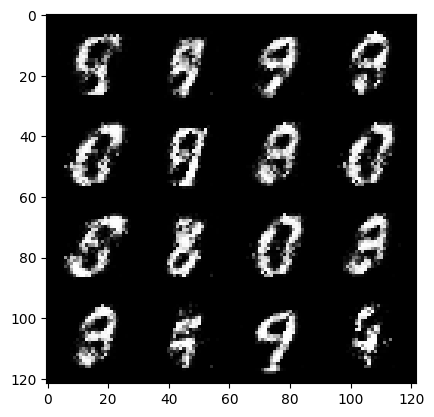

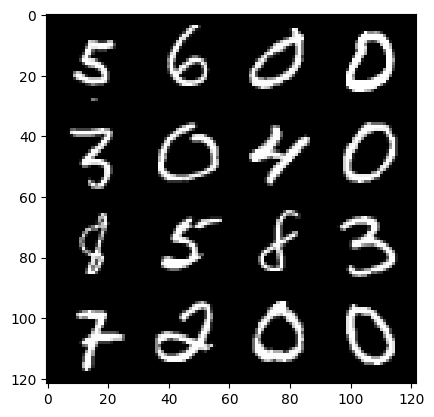

47: step 22200/ Gen Loss : 0.01860927899678548/ disc_loss 0.0003301022450129191


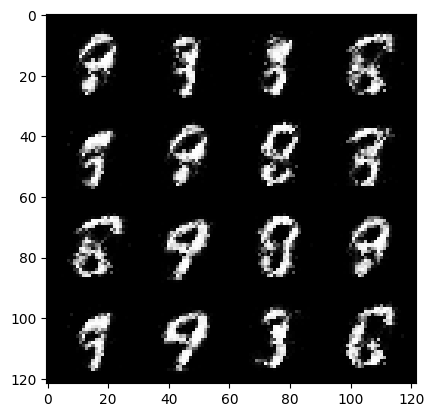

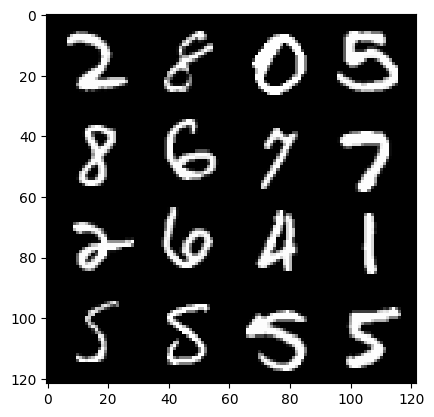

47: step 22500/ Gen Loss : 0.019821513493855795/ disc_loss 0.0002864217261473338


  0%|          | 0/469 [00:00<?, ?it/s]

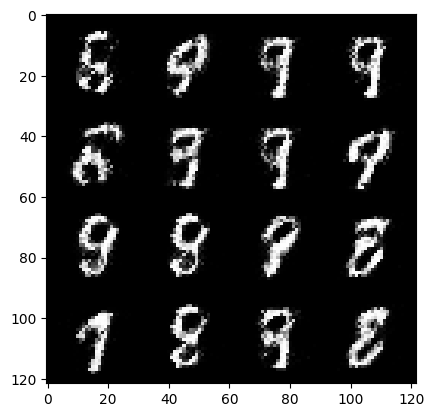

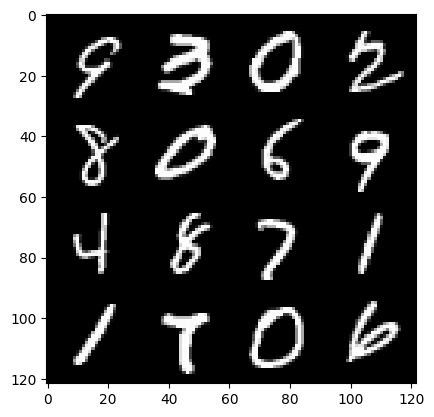

48: step 22800/ Gen Loss : 0.01819231669108073/ disc_loss 0.00015592227379480997


  0%|          | 0/469 [00:00<?, ?it/s]

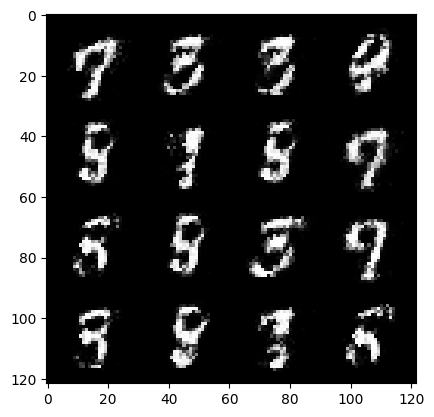

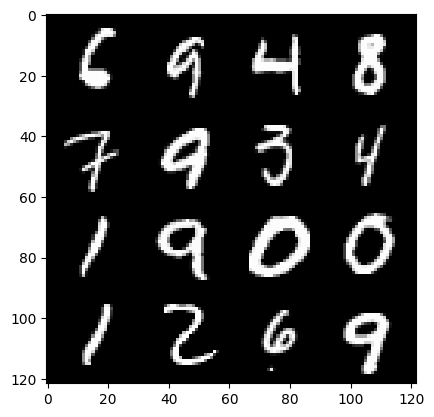

49: step 23100/ Gen Loss : 0.017050809860229492/ disc_loss 0.00014210815231005351


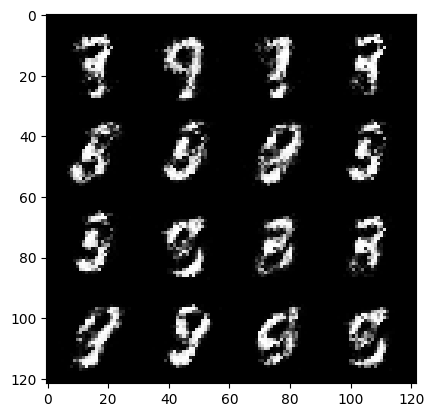

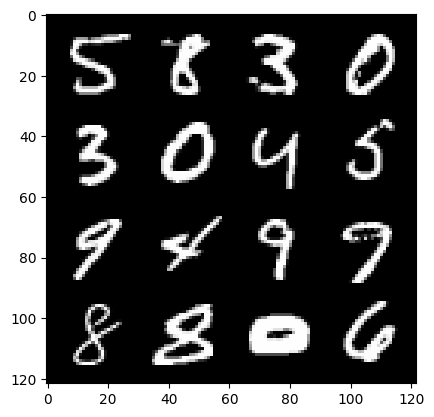

49: step 23400/ Gen Loss : 0.015182371139526368/ disc_loss 0.00014647126197814942


  0%|          | 0/469 [00:00<?, ?it/s]

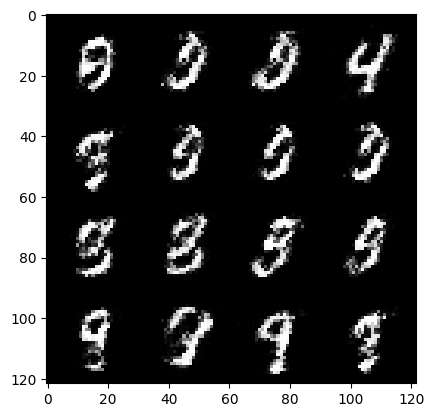

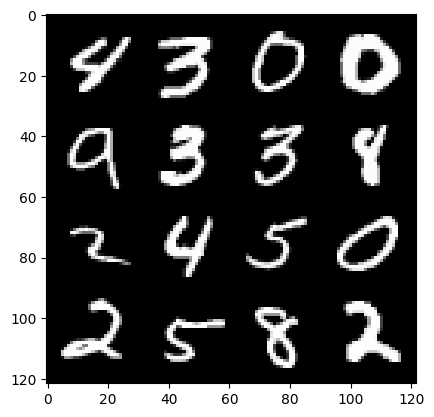

50: step 23700/ Gen Loss : 0.01669675827026367/ disc_loss 0.00011193300286928813


  0%|          | 0/469 [00:00<?, ?it/s]

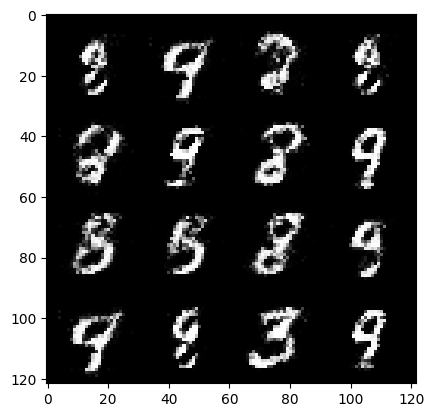

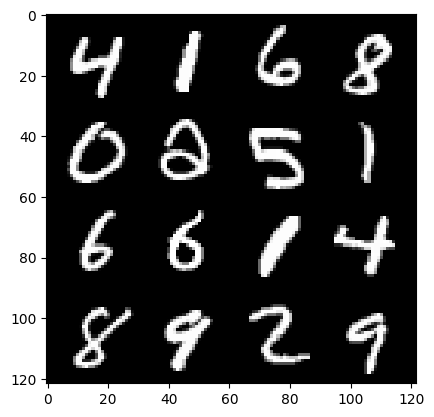

51: step 24000/ Gen Loss : 0.01962855339050293/ disc_loss 0.000287758857011795


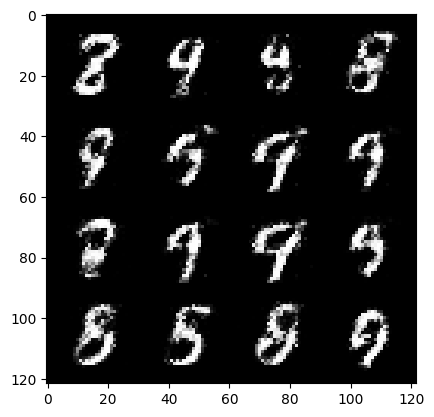

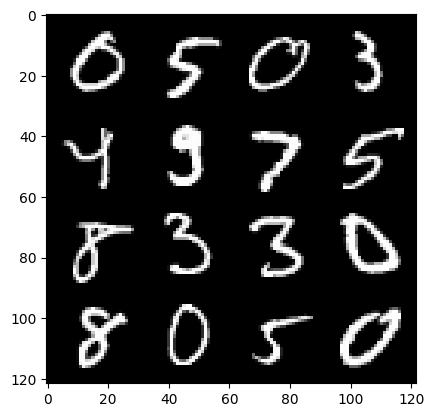

51: step 24300/ Gen Loss : 0.014249871571858724/ disc_loss 0.00014433349172274273


  0%|          | 0/469 [00:00<?, ?it/s]

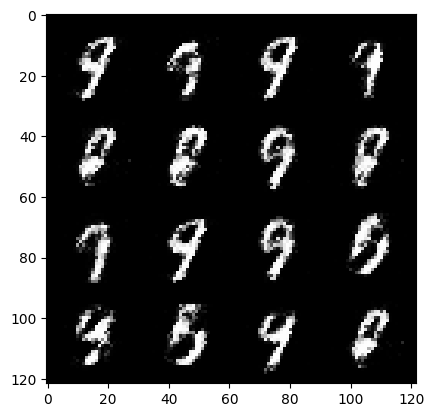

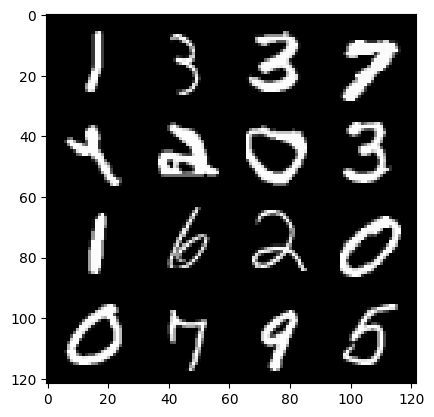

52: step 24600/ Gen Loss : 0.016278514862060545/ disc_loss 0.00026289860407511395


  0%|          | 0/469 [00:00<?, ?it/s]

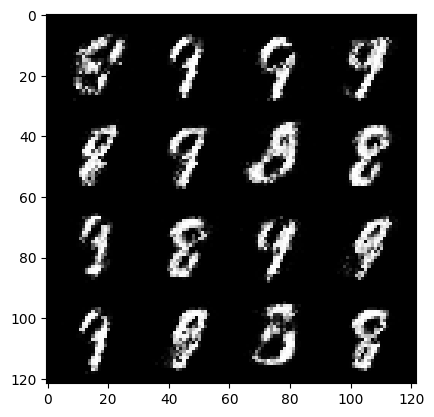

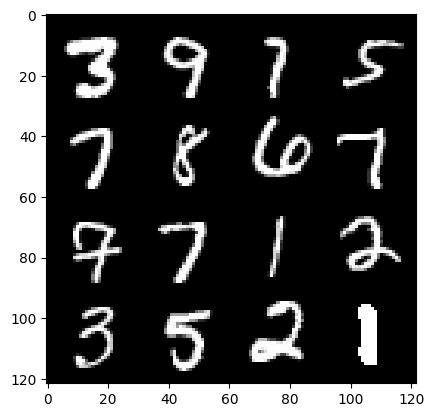

53: step 24900/ Gen Loss : 0.01616788387298584/ disc_loss 0.00018994636833667754


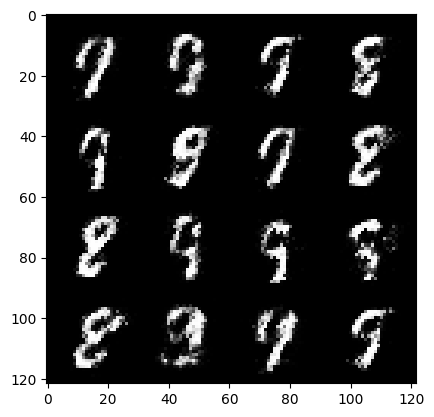

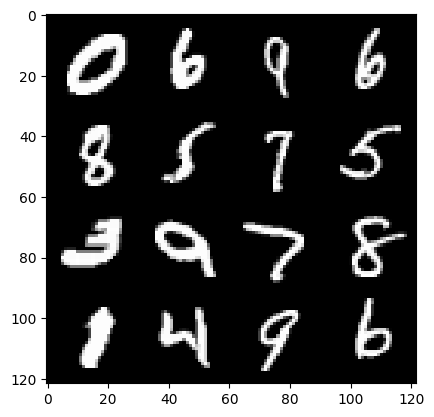

53: step 25200/ Gen Loss : 0.017274842262268067/ disc_loss 0.0002467136333386103


  0%|          | 0/469 [00:00<?, ?it/s]

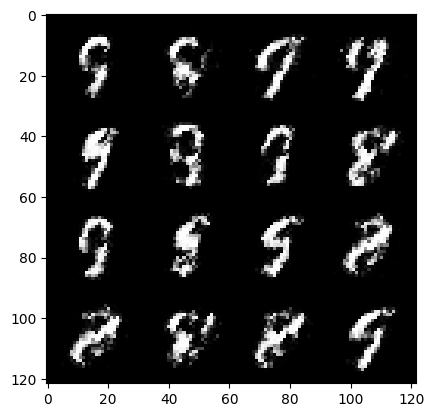

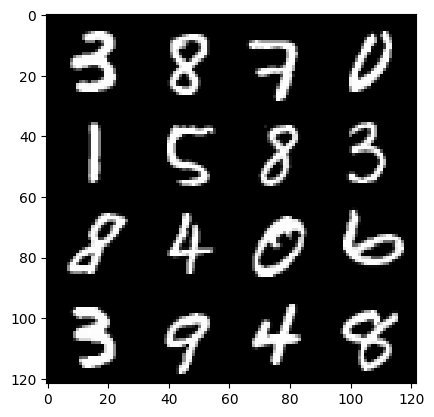

54: step 25500/ Gen Loss : 0.015528694788614909/ disc_loss 0.00010379658391078314


  0%|          | 0/469 [00:00<?, ?it/s]

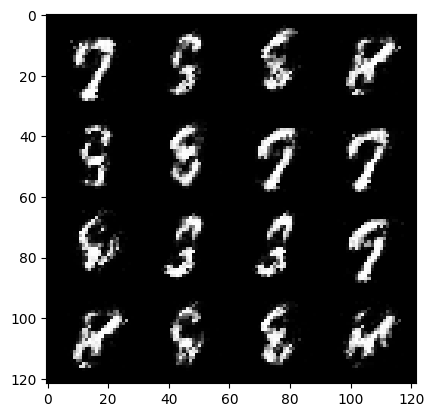

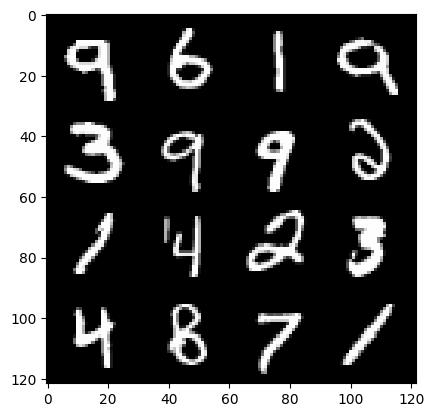

55: step 25800/ Gen Loss : 0.015882323582967123/ disc_loss 0.00022398538887500764


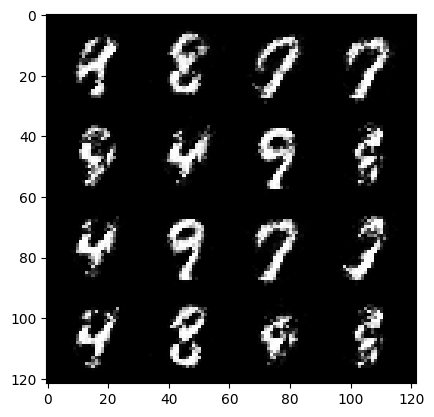

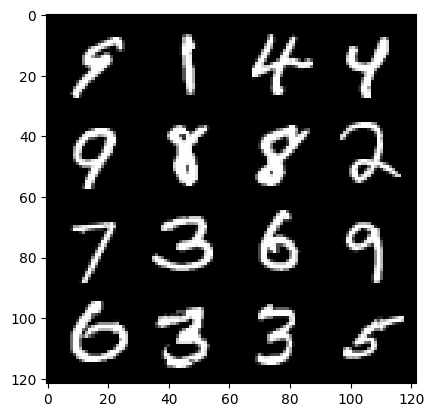

55: step 26100/ Gen Loss : 0.016354894638061522/ disc_loss 0.00022648880879084268


  0%|          | 0/469 [00:00<?, ?it/s]

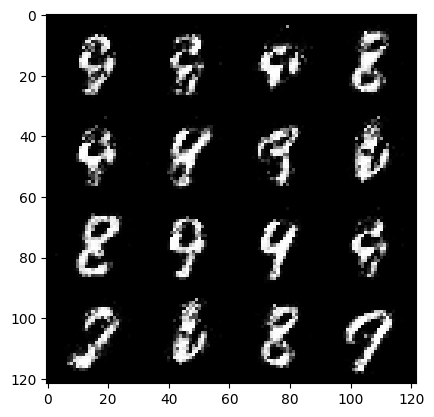

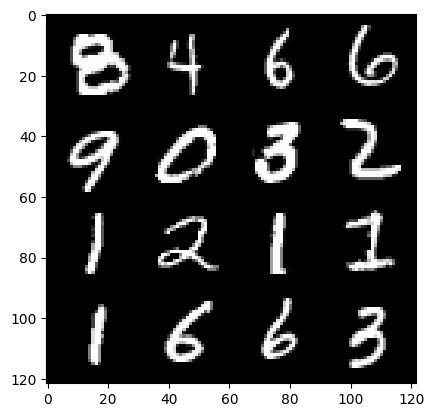

56: step 26400/ Gen Loss : 0.014341400464375815/ disc_loss 0.00013052372882763543


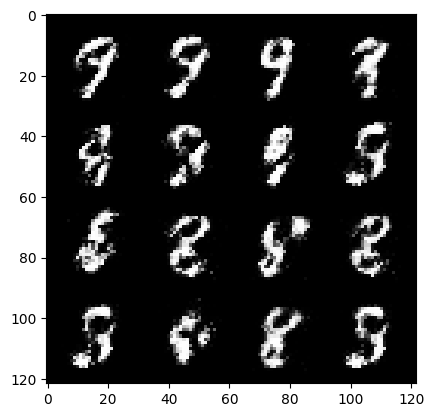

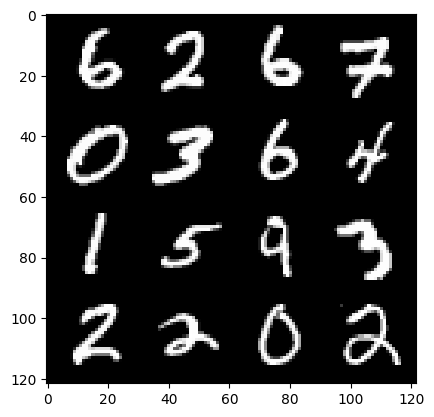

56: step 26700/ Gen Loss : 0.016542509396870932/ disc_loss 0.00024401649832725525


  0%|          | 0/469 [00:00<?, ?it/s]

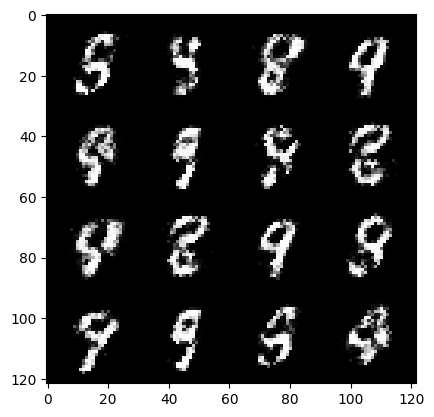

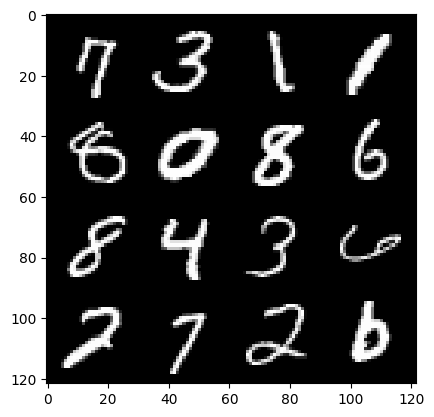

57: step 27000/ Gen Loss : 0.016186405817667643/ disc_loss 0.00020491454750299454


  0%|          | 0/469 [00:00<?, ?it/s]

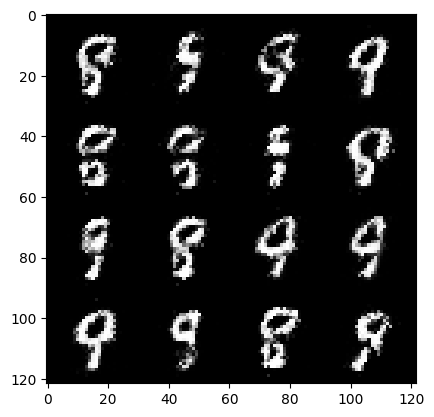

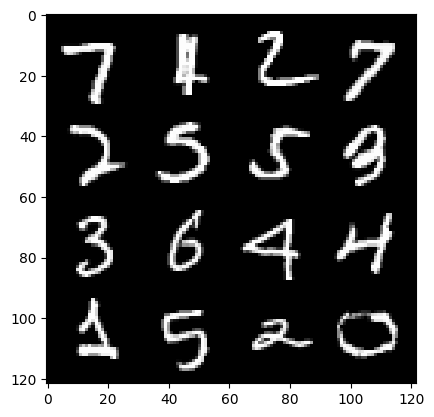

58: step 27300/ Gen Loss : 0.015705615679423014/ disc_loss 0.0003337744375069936


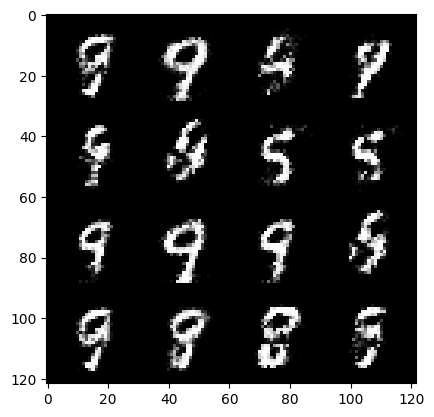

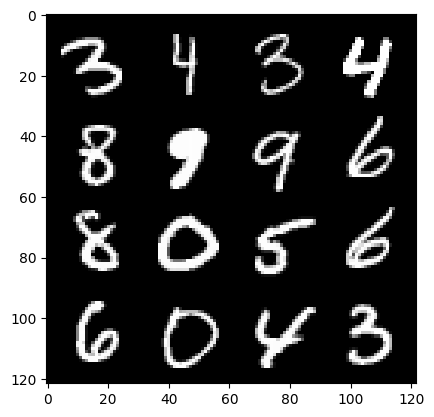

58: step 27600/ Gen Loss : 0.015603141784667969/ disc_loss 0.00040893291433652244


  0%|          | 0/469 [00:00<?, ?it/s]

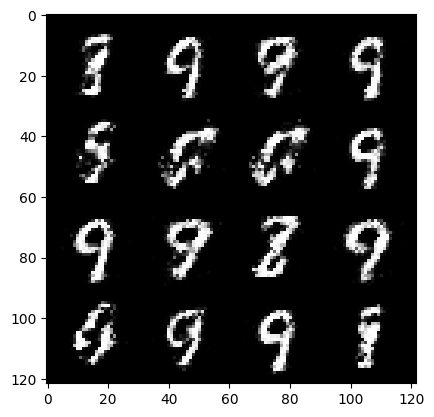

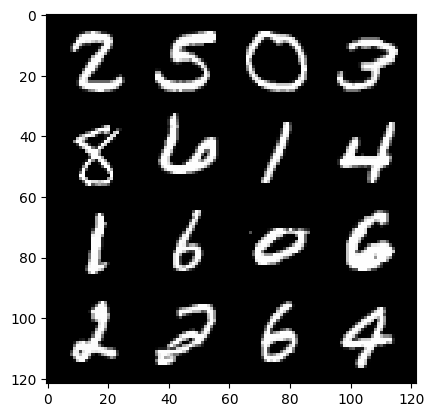

59: step 27900/ Gen Loss : 0.016046660741170247/ disc_loss 0.0001520956556002299


  0%|          | 0/469 [00:00<?, ?it/s]

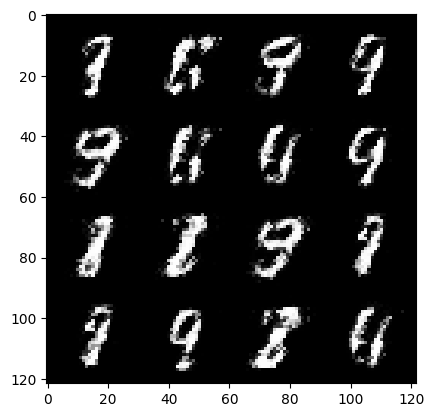

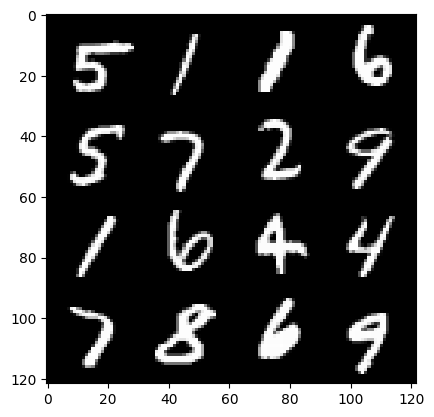

60: step 28200/ Gen Loss : 0.013494761784871419/ disc_loss 0.0002876320481300354


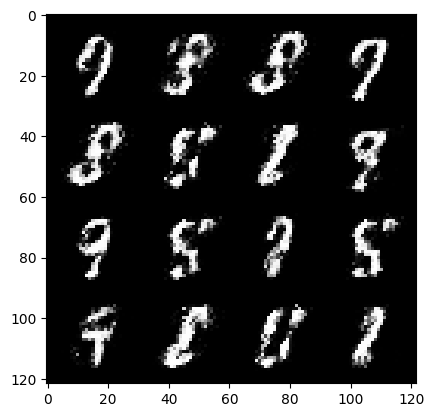

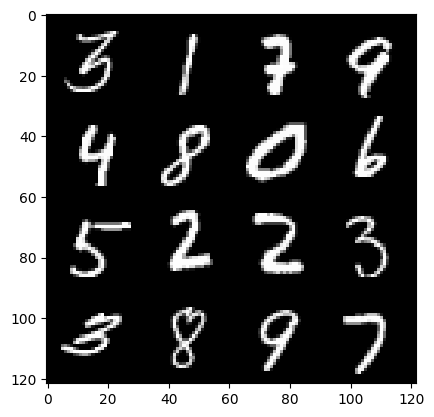

60: step 28500/ Gen Loss : 0.015697774887084962/ disc_loss 0.0003539529691139857


  0%|          | 0/469 [00:00<?, ?it/s]

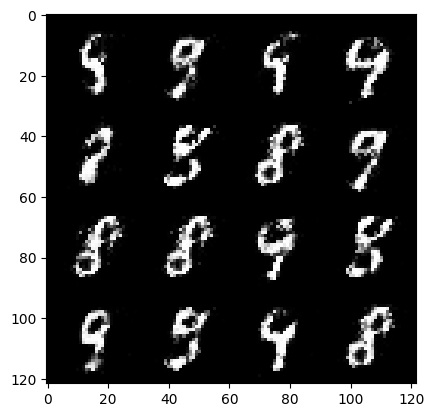

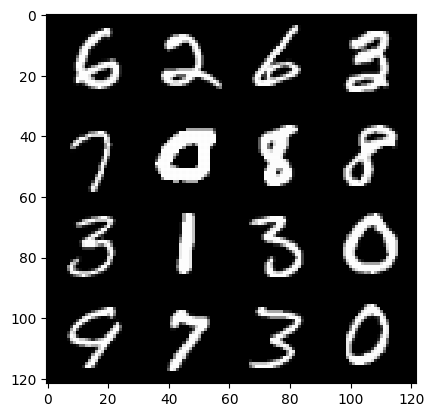

61: step 28800/ Gen Loss : 0.01651823043823242/ disc_loss 0.00043753037850062054


  0%|          | 0/469 [00:00<?, ?it/s]

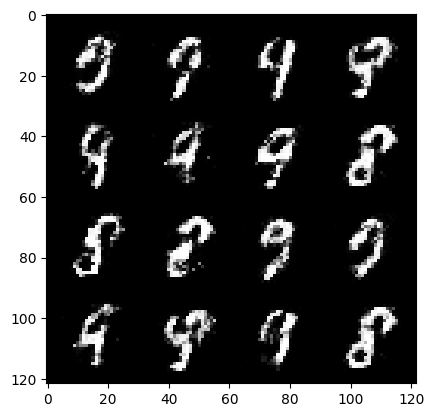

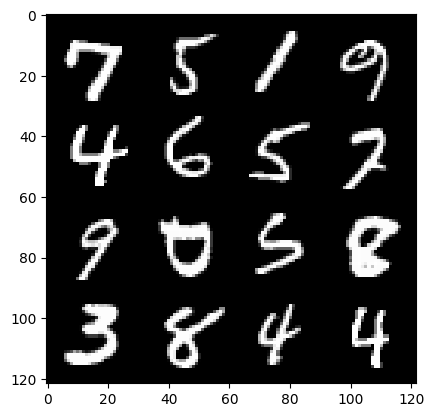

62: step 29100/ Gen Loss : 0.01316229263941447/ disc_loss 0.0004273399213949839


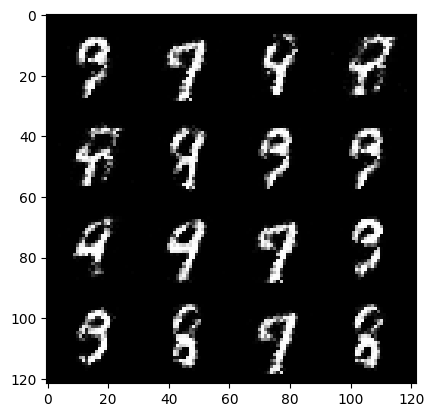

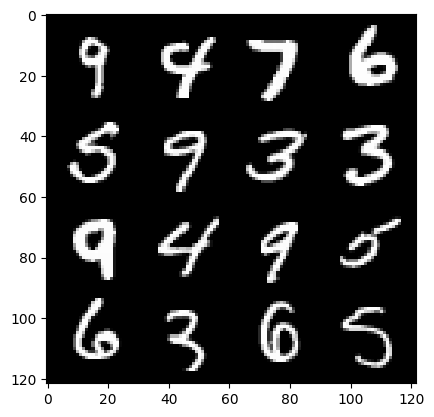

62: step 29400/ Gen Loss : 0.014834775924682617/ disc_loss 0.0002785896261533101


  0%|          | 0/469 [00:00<?, ?it/s]

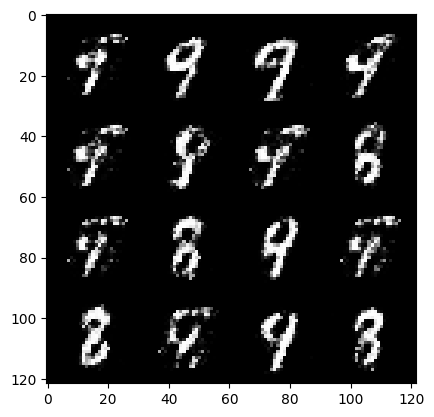

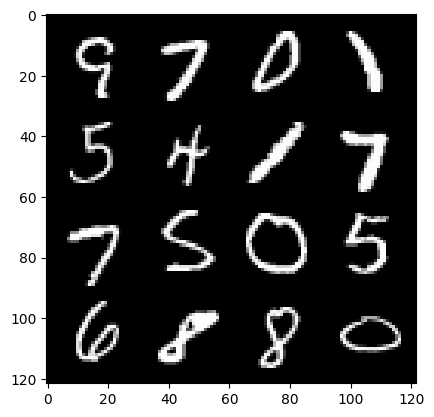

63: step 29700/ Gen Loss : 0.014709668159484863/ disc_loss 0.00020202410717805227


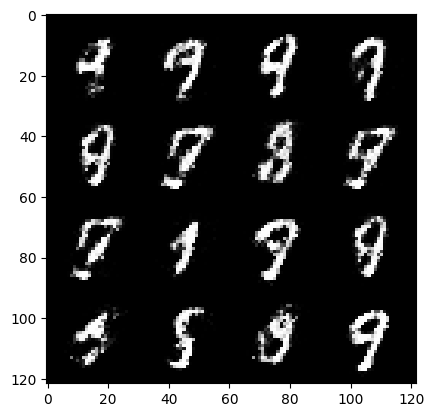

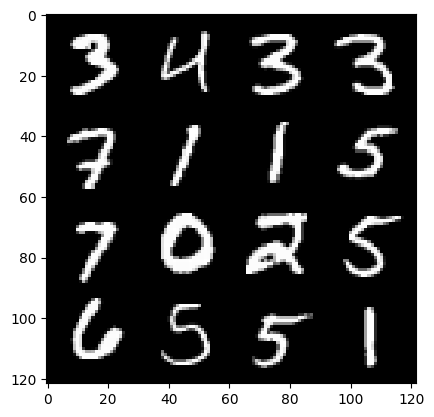

63: step 30000/ Gen Loss : 0.012510293324788412/ disc_loss 0.00036066691080729167


  0%|          | 0/469 [00:00<?, ?it/s]

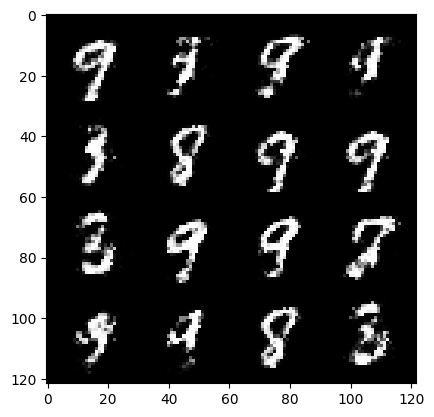

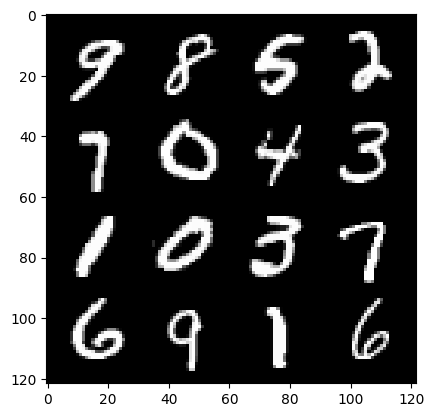

64: step 30300/ Gen Loss : 0.01749956448872884/ disc_loss 8.359406764308612e-05


  0%|          | 0/469 [00:00<?, ?it/s]

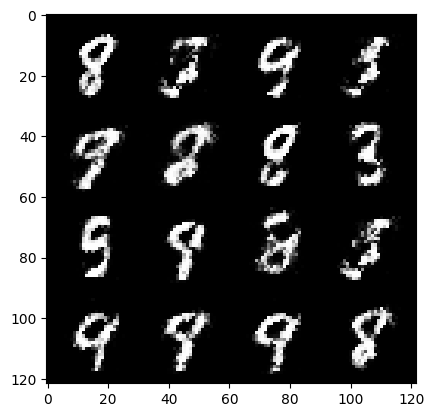

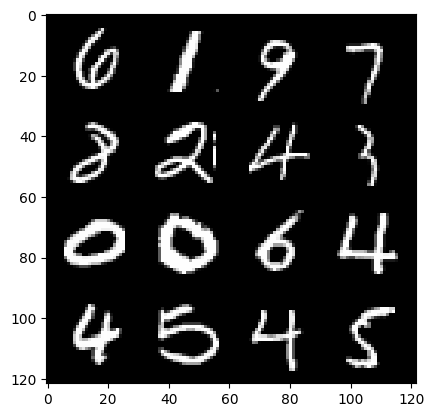

65: step 30600/ Gen Loss : 0.014747333526611329/ disc_loss 0.00019062500447034837


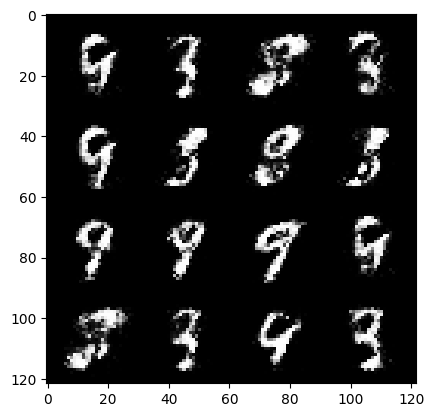

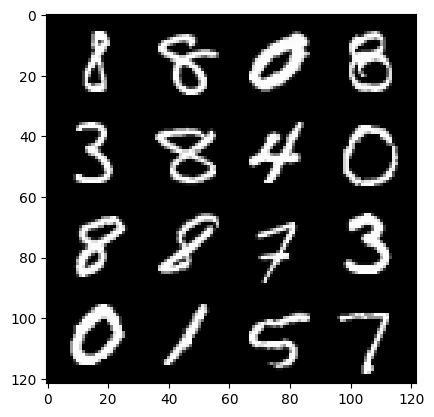

65: step 30900/ Gen Loss : 0.014272796312967935/ disc_loss 0.00034387737512588503


  0%|          | 0/469 [00:00<?, ?it/s]

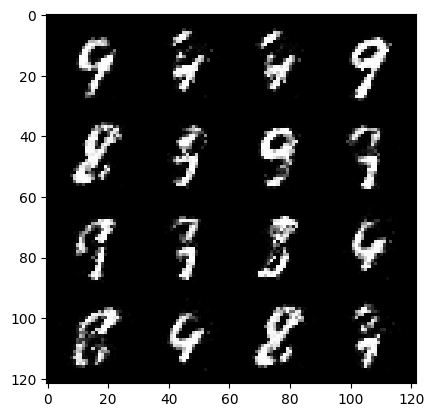

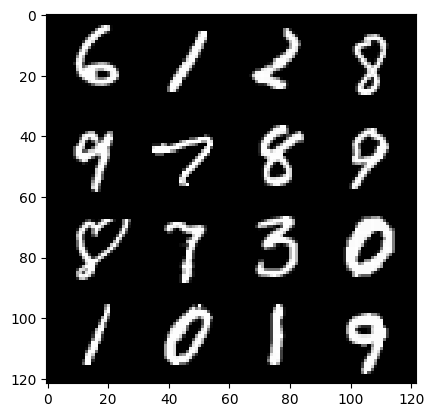

66: step 31200/ Gen Loss : 0.01566776434580485/ disc_loss 0.00021321530143419902


  0%|          | 0/469 [00:00<?, ?it/s]

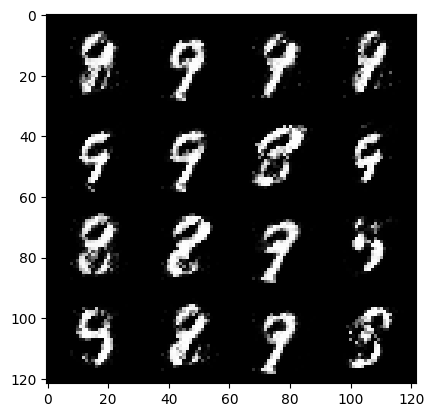

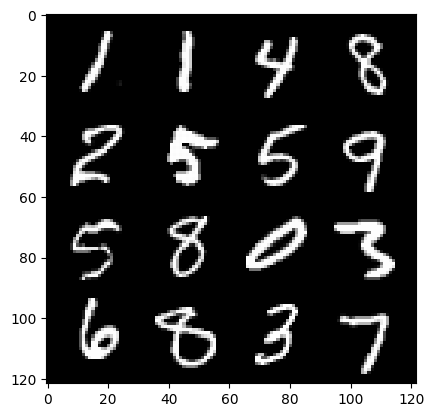

67: step 31500/ Gen Loss : 0.01297840674718221/ disc_loss 0.00037801943719387057


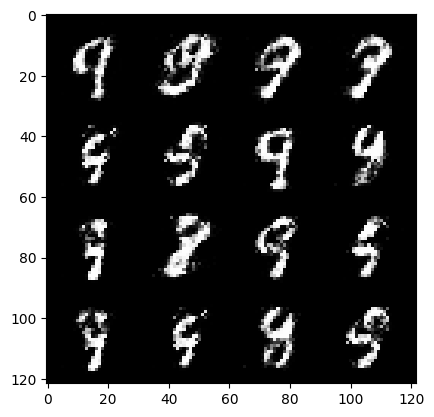

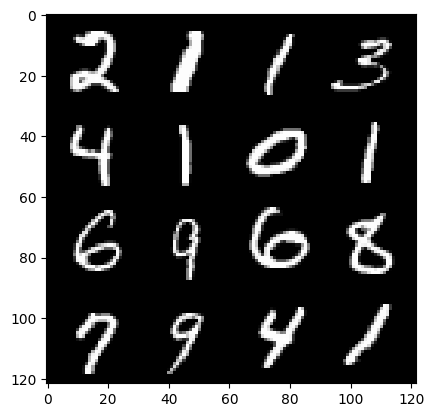

67: step 31800/ Gen Loss : 0.0170317014058431/ disc_loss 0.00041761855284372964


  0%|          | 0/469 [00:00<?, ?it/s]

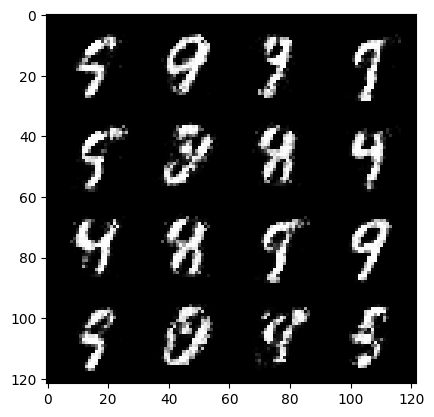

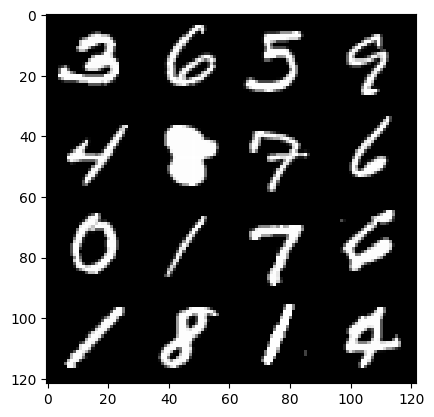

68: step 32100/ Gen Loss : 0.015334768295288086/ disc_loss 0.00040341816842556


  0%|          | 0/469 [00:00<?, ?it/s]

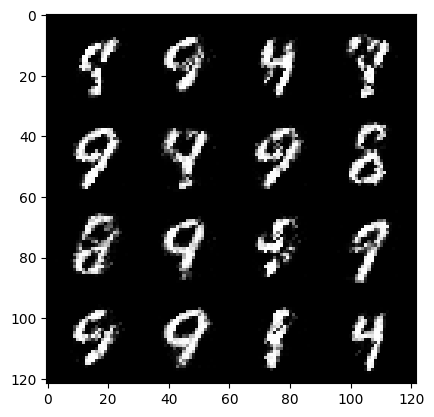

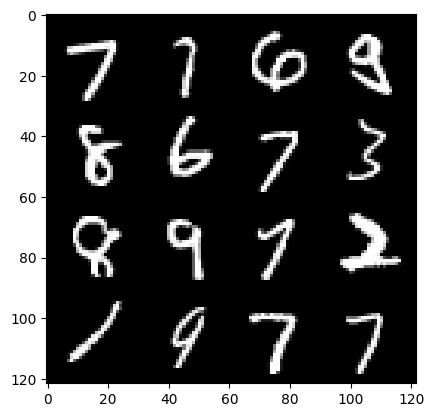

69: step 32400/ Gen Loss : 0.01321055253346761/ disc_loss 0.0003659099092086156


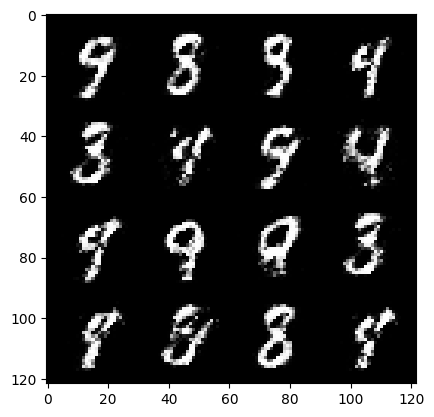

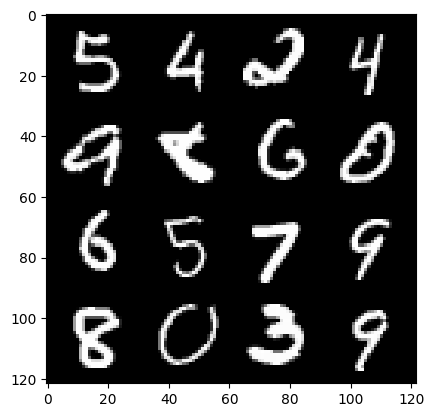

69: step 32700/ Gen Loss : 0.014746276537577312/ disc_loss 0.00036706383029619854


  0%|          | 0/469 [00:00<?, ?it/s]

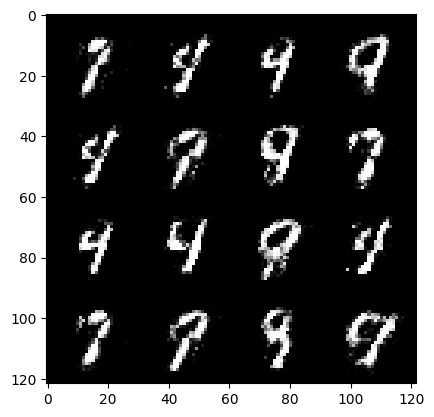

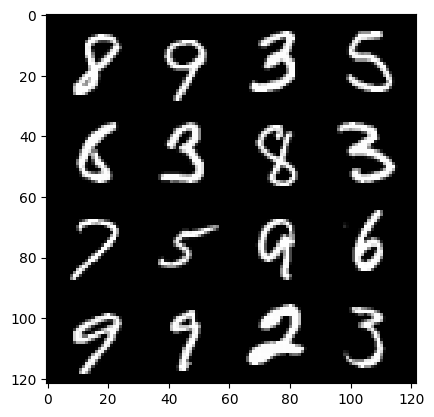

70: step 33000/ Gen Loss : 0.016413160959879557/ disc_loss 0.00036383502185344696


  0%|          | 0/469 [00:00<?, ?it/s]

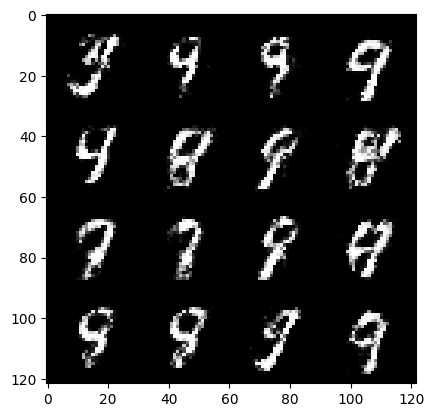

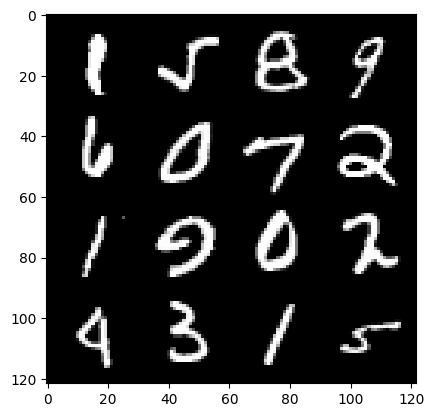

71: step 33300/ Gen Loss : 0.01439809799194336/ disc_loss 0.00046381890773773194


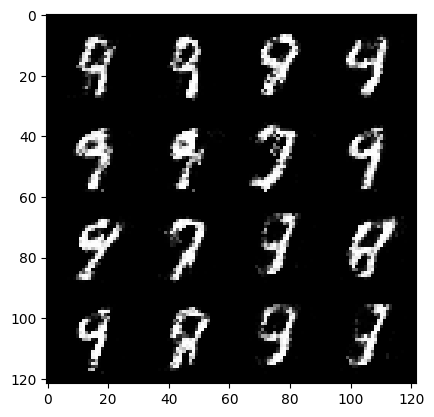

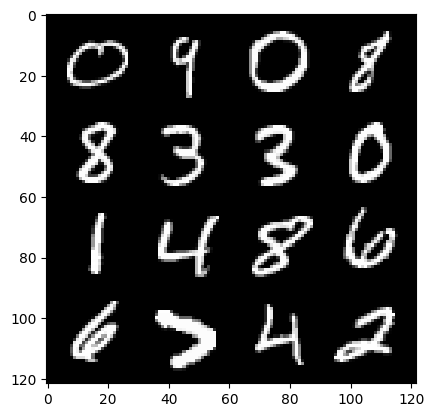

71: step 33600/ Gen Loss : 0.015103891690572102/ disc_loss 0.00029638173679510753


  0%|          | 0/469 [00:00<?, ?it/s]

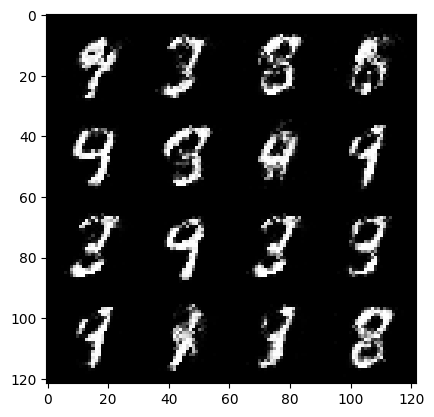

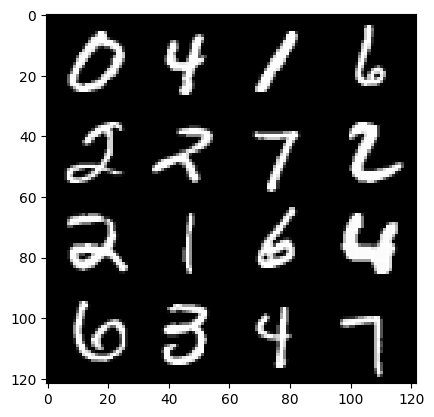

72: step 33900/ Gen Loss : 0.013915154139200846/ disc_loss 0.0002070757249991099


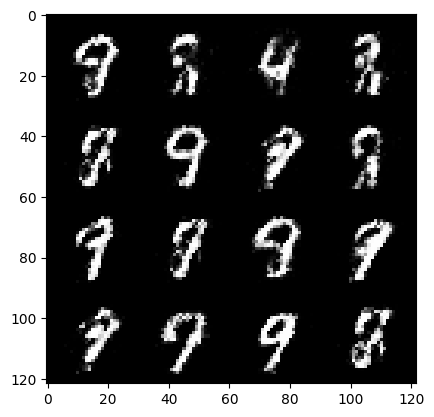

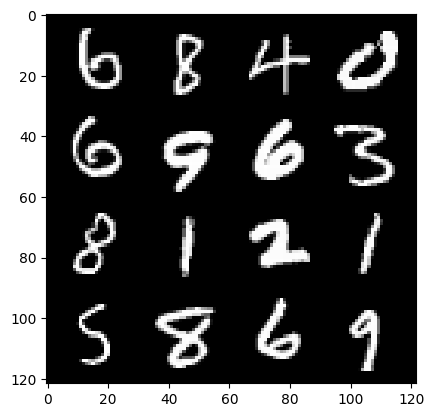

72: step 34200/ Gen Loss : 0.014508832295735677/ disc_loss 0.00042134036620457966


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [15]:
#training loop

#60000/128 = 469

for epoch in range(epochs):
  for real,_ in tqdm(dataloader):   #no need of labels as this is not supervised learning
    #discriminator
    disc_opt.zero_grad()

    cur_bs = len(real) #real 128*1*1*28
    real = real.view(cur_bs, -1) #128*784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    #generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func, gen , disc, cur_bs, z_dim)
    gen_loss.backward(retain_graph = True)
    gen_opt.step()

    mean_disc_loss = disc_loss.item()/info_step
    mean_gen_loss = gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_bs>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake= gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step}/ Gen Loss : {mean_gen_loss}/ disc_loss {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0,0
    cur_step += 1
